In [1]:
gpus = [1]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from utils import *
from scipy.spatial import distance
import seaborn as sns
import umap

In [3]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [4]:
morph_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli')

results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/morph')
spec_file = os.path.join(morph_folder, 'specs_star.p')

In [5]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [6]:
stim_cats = spec_df.stim.unique().tolist()

In [7]:
spec_list = spec_df.spec.values.tolist()

In [8]:
h, w = spec_list[0].shape

In [9]:
print(h, w)

298 76


## make model and load weights

In [10]:
clear_session()

In [11]:
model=self_VGG()

In [12]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
model_outputs = model(resized)
feature_extractor = Model(model_inputs, model_outputs)

In [14]:
def distance_ratio(d1, d2):
    """
    compare the distance between v0-v1 and v0-v2, then put the recognition confidence between v1 and v2"""
    return d1/(d1+d2)

In [15]:
def distance_to_confidence(v0, v1, v2, dist_func):
    """
    compare the distance between v0-v1 and v0-v2, then put the recognition confidence between v1 and v2"""
    d01 = dist_func(v0, v1)
    d02 = dist_func(v0, v2)
    if d01<0.001:
        return 0
    elif d02<0.001:
        return 1
    else:
#         return np.exp(1/d02)/(np.exp(1/d01)+np.exp(1/d02))
        return (1/d02)/(1/d01+1/d02)

In [16]:
def min_distance(v0, v1, v2, dist_func):
    """
    compare the distance between v0-v1 and v0-v2, then return the smaller one"""
    d01 = dist_func(v0, v1)
    d02 = dist_func(v0, v2)
    return min(d01, d02)

In [17]:
def avrg_distance(v0, v1, v2, dist_func):
    """
    compare the distance between v0-v1 and v0-v2, then return the average"""
    d01 = dist_func(v0, v1)
    d02 = dist_func(v0, v2)
    return np.mean([d01, d02])

In [18]:
def flip_at_peak(list1, list2, monotonous=False):
    """
    compare the values in list 1 (monotonously increasing) and list 2 (monotonously decreasing),
    start with list 1 values, once they cross, flip list 2 values based on cross value"""
    
    if monotonous:
        cross_index = np.argmin(np.abs(np.array(list1)-np.array(list2)))
    else:
        diff = np.array(list1)-np.array(list2)
        l1high_indeces = [i for i in range(len(list1)-2) if (diff[i]>0) and (diff[i+1]>0) and (diff[i+2]>0)]
        cross_index = l1high_indeces[0]
    peak_val = list1[cross_index]
    comb_list = list1[:cross_index]+list(2*peak_val-np.array(list2[cross_index:]))
    
    return comb_list

# Group 1 (ABCD vs EFGH)

In [40]:
group_stim_cats = generate_stim_combos('abcd', 'efgh')

In [41]:
weights_file = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group1/weights-improvement.h5')
feature_extractor.load_weights(weights_file, by_name=True)

In [43]:
cat_list = []
id_list = []
feature_rmse_list_init = []
feature_cosine_list_init = []
spec_rmse_list_init = []
feature_rmse_list_final = []
feature_cosine_list_final = []
spec_rmse_list_final = []
less_dim_list = []
more_dim_list = []

feature_rmse_list_comb = []
feature_cosine_list_comb = []
spec_rmse_list_comb = []

feature_rmse_list_norm = []
feature_cosine_list_norm = []
spec_rmse_list_norm = []


for cat in group_stim_cats:
    cat_specs = spec_df[spec_df.stim==cat].reset_index(drop=True)
    
    # cat lists
    feature_rmse_list_init_cat = []
    feature_cosine_list_init_cat = []
    spec_rmse_list_init_cat = []
    
    feature_rmse_list_final_cat = []
    feature_cosine_list_final_cat = []
    spec_rmse_list_final_cat = []
    
    # init value
    init_spec = cat_specs[cat_specs.id==1].spec.values[0]
    init_spec_3d = np.stack([init_spec, init_spec, init_spec], axis = 2)
    init_features = np.squeeze(feature_extractor.predict(np.expand_dims(init_spec_3d, axis=0)))
    
    # last value
    final_spec = cat_specs[cat_specs.id==128].spec.values[0]
    final_spec_3d = np.stack([final_spec, final_spec, final_spec], axis = 2)
    final_features = np.squeeze(feature_extractor.predict(np.expand_dims(final_spec_3d, axis=0)))
    
    # diff
    max_feature_rmse = rmse(init_features, final_features)
    max_feature_cosine = distance.cosine(init_features, final_features)
    max_spec_rmse = rmse(init_spec_3d, final_spec_3d)
    
    # iterate through morphs
    for _, spec_i, _, spec in cat_specs.values:
        spec_3d = np.stack([spec, spec, spec], axis = 2)

        spec_features = np.squeeze(feature_extractor.predict(np.expand_dims(spec_3d, axis=0)))
        
        init_feature_rmse = rmse(init_features, spec_features)
        final_feature_rmse = rmse(final_features, spec_features)
        init_feature_cosine = distance.cosine(init_features, spec_features)
        final_feature_cosine = distance.cosine(final_features, spec_features)
        init_spec_rmse = rmse(init_spec_3d, spec_3d)
        final_spec_rmse = rmse(final_spec_3d, spec_3d)
        
#         if init_feature_rmse>final_feature_rmse:
#             feature_rmse = max_feature_rmse-final_feature_rmse
#         else:
#             feature_rmse = init_feature_rmse
        
#         if init_feature_cosine>final_feature_cosine:
#             feature_cosine = max_feature_cosine-final_feature_cosine
#         else:
#             feature_cosine = init_feature_cosine
        
#         if init_spec_rmse>final_spec_rmse:
#             spec_rmse = max_spec_rmse-final_spec_rmse
#         else:
#             spec_rmse = init_spec_rmse

#         feature_cosine = (max_feature_cosine-final_feature_cosine+init_feature_cosine)/2
#         feature_rmse = (max_feature_rmse-final_feature_rmse+init_feature_rmse)/2
#         spec_rmse = (max_spec_rmse-final_spec_rmse+init_spec_rmse)/2

#         spec_rmse = distance_to_confidence(spec_3d, init_spec_3d, final_spec_3d, rmse)
#         feature_rmse = distance_to_confidence(spec_features, init_features, final_features, rmse)
#         feature_cosine = distance_to_confidence(spec_features, init_features, final_features, distance.cosine)
#         spec_rmse = avrg_distance(spec_3d, init_spec_3d, final_spec_3d, rmse)
#         feature_rmse = avrg_distance(spec_features, init_features, final_features, rmse)
#         feature_cosine = avrg_distance(spec_features, init_features, final_features, distance.cosine)
        
        
        cat_list.append(cat)
        less_dim_list.append(cat[0])
        more_dim_list.append(cat[1])
        id_list.append(spec_i)
        
#         feature_rmse_list.append(feature_rmse)
#         feature_cosine_list.append(feature_cosine)
#         spec_rmse_list.append(spec_rmse)
        feature_rmse_list_init_cat.append(init_feature_rmse)
        feature_rmse_list_final_cat.append(final_feature_rmse)
        feature_cosine_list_init_cat.append(init_feature_cosine)
        feature_cosine_list_final_cat.append(final_feature_cosine)
        spec_rmse_list_init_cat.append(init_spec_rmse)
        spec_rmse_list_final_cat.append(final_spec_rmse)
        
    feature_rmse_list_init += feature_rmse_list_init_cat
    feature_rmse_list_final += feature_rmse_list_final_cat
    feature_cosine_list_init += feature_cosine_list_init_cat
    feature_cosine_list_final += feature_cosine_list_final_cat
    spec_rmse_list_init += spec_rmse_list_init_cat
    spec_rmse_list_final += spec_rmse_list_final_cat
    
    feature_rmse_list_comb_cat = flip_at_peak(feature_rmse_list_init_cat, feature_rmse_list_final_cat)
    feature_cosine_list_comb_cat = flip_at_peak(feature_cosine_list_init_cat, feature_cosine_list_final_cat)
    spec_rmse_list_comb_cat = flip_at_peak(spec_rmse_list_init_cat, spec_rmse_list_final_cat, monotonous=True)
    
    feature_rmse_list_comb += feature_rmse_list_comb_cat
    feature_cosine_list_comb += feature_cosine_list_comb_cat
    spec_rmse_list_comb += spec_rmse_list_comb_cat
    
    feature_rmse_list_norm += list(np.abs(feature_rmse_list_comb_cat)/np.max(feature_rmse_list_comb_cat))
    feature_cosine_list_norm += list(np.abs(feature_cosine_list_comb_cat)/np.max(feature_cosine_list_comb_cat))
    spec_rmse_list_norm += list(np.abs(spec_rmse_list_comb_cat)/np.max(spec_rmse_list_comb_cat))
    
    paragraph_print(f'Done with {cat}', separation='*')

Done with ae
**************************************************
Done with af
**************************************************
Done with ag
**************************************************
Done with ah
**************************************************
Done with be
**************************************************
Done with bf
**************************************************
Done with bg
**************************************************
Done with bh
**************************************************
Done with ce
**************************************************
Done with cf
**************************************************
Done with cg
**************************************************
Done with ch
**************************************************
Done with de
**************************************************
Done with df
**************************************************
Done with dg
**************************************************
Done with dh
***************************

In [44]:
morph_df_sym = pd.DataFrame()
morph_df_sym['morph_dim'] = cat_list
morph_df_sym['id'] = id_list

morph_df_sym['lesser_dim'] = less_dim_list
morph_df_sym['greater_dim'] = more_dim_list
morph_df_sym['init_feature_rmse'] = feature_rmse_list_init
morph_df_sym['final_feature_rmse'] = feature_rmse_list_final
morph_df_sym['init_feature_cosine'] = feature_cosine_list_init
morph_df_sym['final_feature_cosine'] = feature_cosine_list_final
morph_df_sym['init_spec_rmse'] = spec_rmse_list_init
morph_df_sym['final_spec_rmse'] = spec_rmse_list_final

morph_df_sym['comb_feature_rmse'] = feature_rmse_list_comb
morph_df_sym['comb_feature_cosine'] = feature_cosine_list_comb
morph_df_sym['comb_spec_rmse'] = spec_rmse_list_comb

morph_df_sym['norm_feature_rmse'] = feature_rmse_list_norm
morph_df_sym['norm_feature_cosine'] = feature_cosine_list_norm
morph_df_sym['norm_spec_rmse'] = spec_rmse_list_norm

In [45]:
morph_df_sym.head()

,morph_dim,id,lesser_dim,greater_dim,init_feature_rmse,final_feature_rmse,init_feature_cosine,final_feature_cosine,init_spec_rmse,final_spec_rmse,comb_feature_rmse,comb_feature_cosine,comb_spec_rmse,norm_feature_rmse,norm_feature_cosine,norm_spec_rmse
0,ae,1,a,e,0.000000,0.551171,0.000000,0.706243,0.000000,0.278840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,ae,2,a,e,0.028815,0.527265,0.000432,0.689333,0.010870,0.278188,0.028815,0.000432,0.010870,0.030366,0.000384,0.025536
2,ae,3,a,e,0.049293,0.511064,0.001214,0.679294,0.016957,0.277632,0.049293,0.001214,0.016957,0.051947,0.001081,0.039835
3,ae,4,a,e,0.074563,0.490645,0.003307,0.660766,0.021380,0.278018,0.074563,0.003307,0.021380,0.078577,0.002945,0.050227
4,ae,5,a,e,0.090975,0.477298,0.005139,0.648345,0.024051,0.277325,0.090975,0.005139,0.024051,0.095873,0.004577,0.056502


In [72]:
morph_df_sym.to_pickle(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group1', 
                                    'morph_comb.p'))

In [5]:
morph_df_sym = pickle.load(open(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group1', 
                                             'morph_comb.p'), 'rb'))

In [6]:
morph_df_sym.head()

,morph_dim,id,lesser_dim,greater_dim,init_feature_rmse,final_feature_rmse,init_feature_cosine,final_feature_cosine,init_spec_rmse,final_spec_rmse,comb_feature_rmse,comb_feature_cosine,comb_spec_rmse,norm_feature_rmse,norm_feature_cosine,norm_spec_rmse
0,ae,1,a,e,0.000000,0.551171,0.000000,0.706243,0.000000,0.278840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,ae,2,a,e,0.028815,0.527265,0.000432,0.689333,0.010870,0.278188,0.028815,0.000432,0.010870,0.030366,0.000384,0.025536
2,ae,3,a,e,0.049293,0.511064,0.001214,0.679294,0.016957,0.277632,0.049293,0.001214,0.016957,0.051947,0.001081,0.039835
3,ae,4,a,e,0.074563,0.490645,0.003307,0.660766,0.021380,0.278018,0.074563,0.003307,0.021380,0.078577,0.002945,0.050227
4,ae,5,a,e,0.090975,0.477298,0.005139,0.648345,0.024051,0.277325,0.090975,0.005139,0.024051,0.095873,0.004577,0.056502


In [20]:
row_dict = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5}
col_dict = {'c':0, 'd':1, 'e':2, 'f':3, 'g':4, 'h':5}

## RMSE

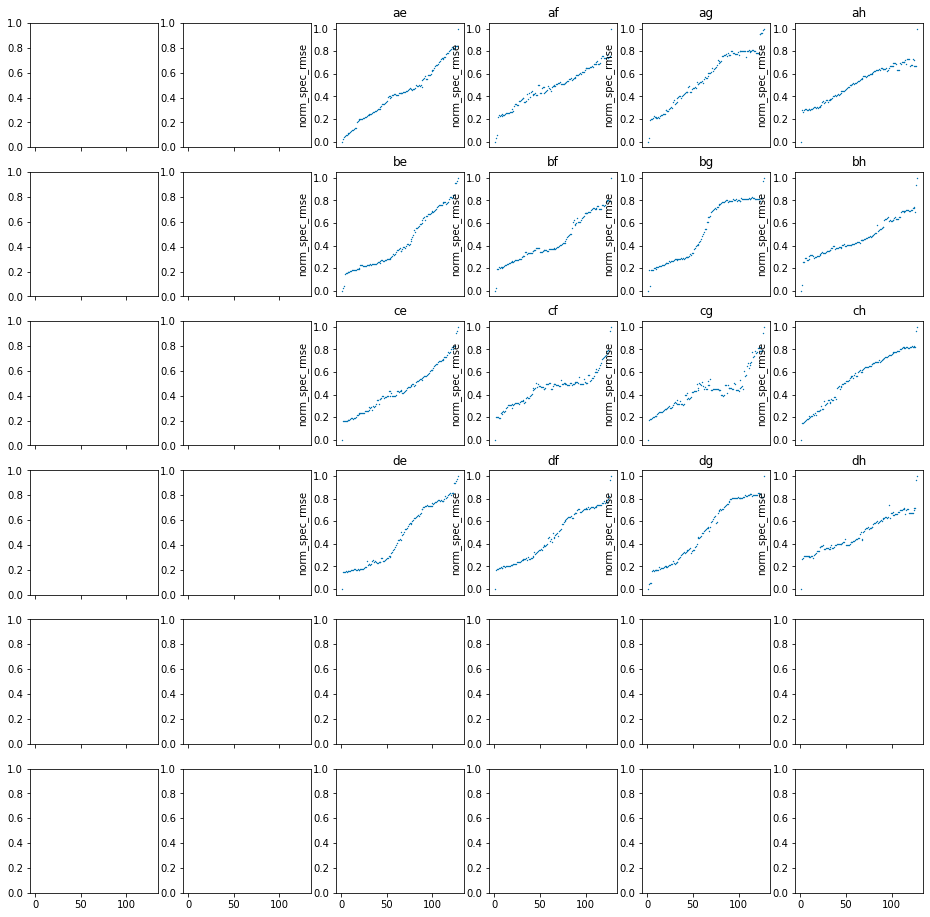

In [13]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='norm_spec_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
#     ax[row][col].get_yaxis().set_visible(False)

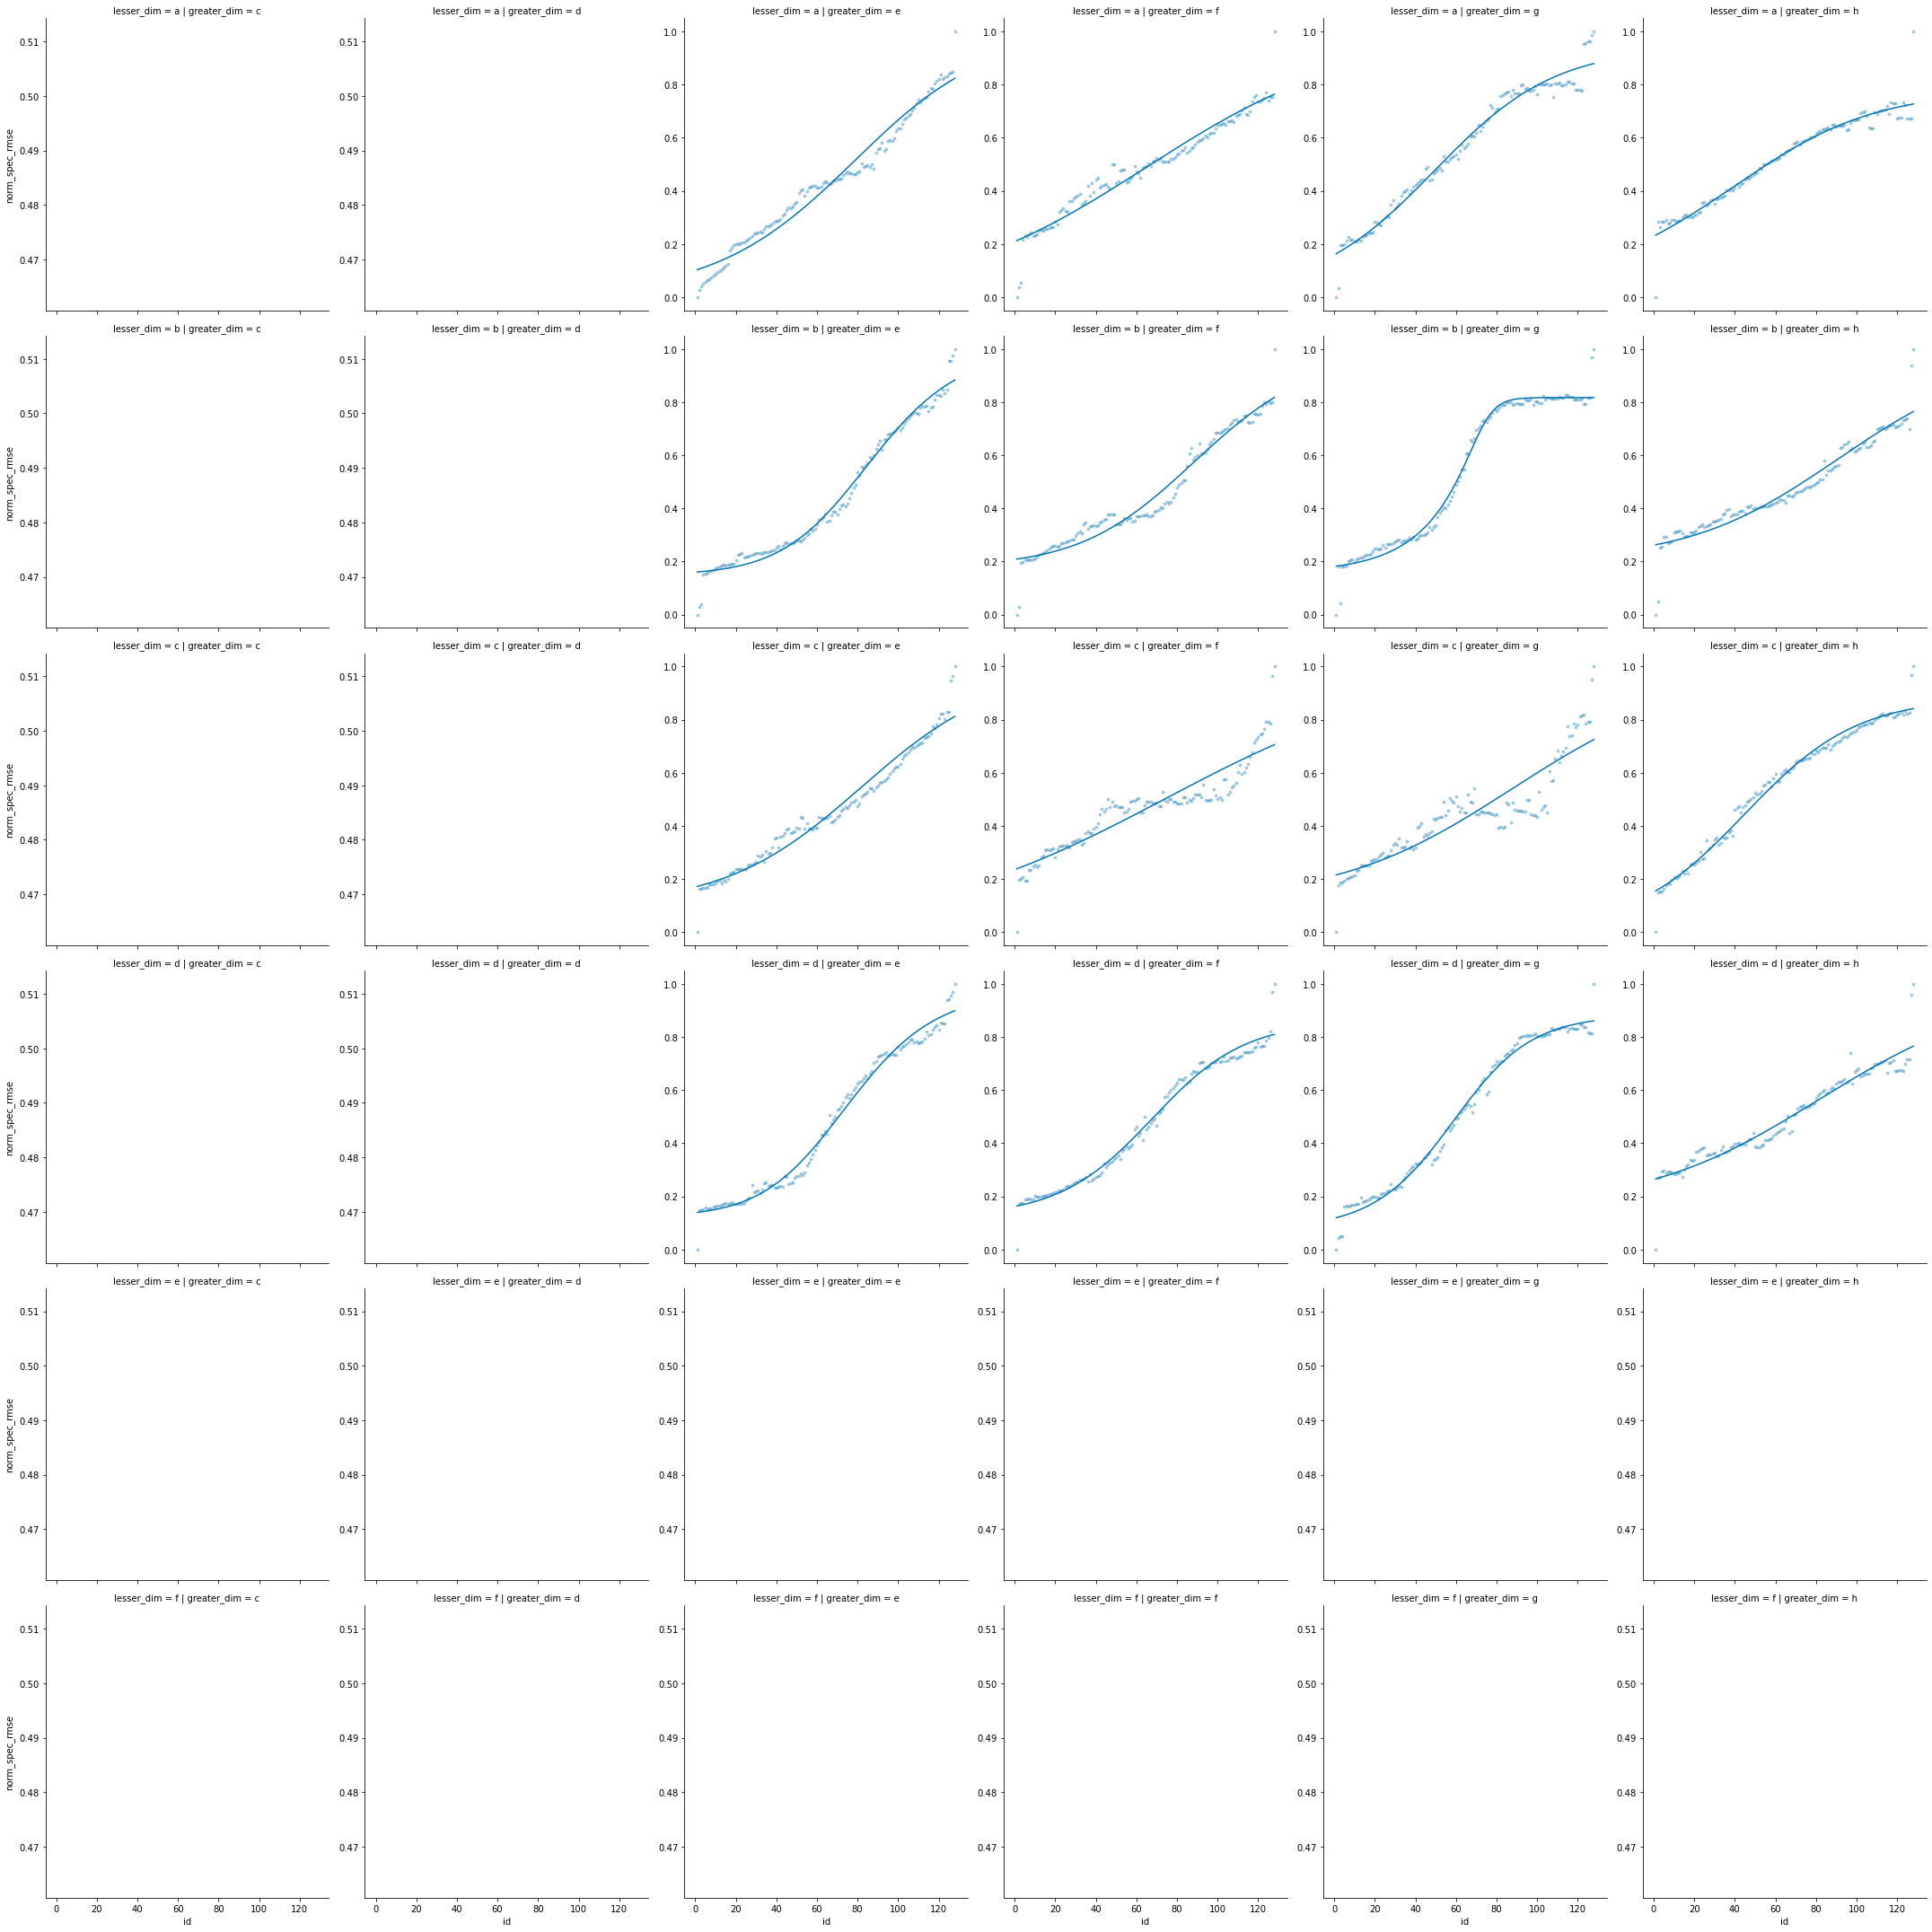

In [14]:
g = sns.lmplot(data=morph_df_sym, 
           x='id', 
           y='norm_spec_rmse', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(fivepl, "id", "norm_spec_rmse")

In [23]:
group1_rmse = {}
for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    ids = np.array(reduced_morph_df.id.values.tolist())
    loss = np.array(reduced_morph_df.norm_spec_rmse.values.tolist())
    group1_rmse[morph_dim] = fit_4pl(ids, loss)

In [24]:
group1_df_rmse = pd.DataFrame.from_dict(group1_rmse, 
                                            orient='index', 
                                            columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()

In [25]:
group1_df_rmse['group'] = 'Group 1'
group1_df_rmse['metric'] = 'rmse'

group1_df_rmse.head()

,index,min_val,max_val,slope,inflection,group,metric
0,ae,1.000000e-16,1.000000,0.029308,76.226299,Group 1,rmse
1,af,1.000000e-16,0.925953,0.021387,58.667611,Group 1,rmse
2,ag,1.000000e-16,0.977344,0.030870,52.000076,Group 1,rmse
3,ah,1.000000e-16,0.795719,0.026042,35.582889,Group 1,rmse
4,be,1.402487e-01,1.000000,0.045282,86.134743,Group 1,rmse


## feature RMSE

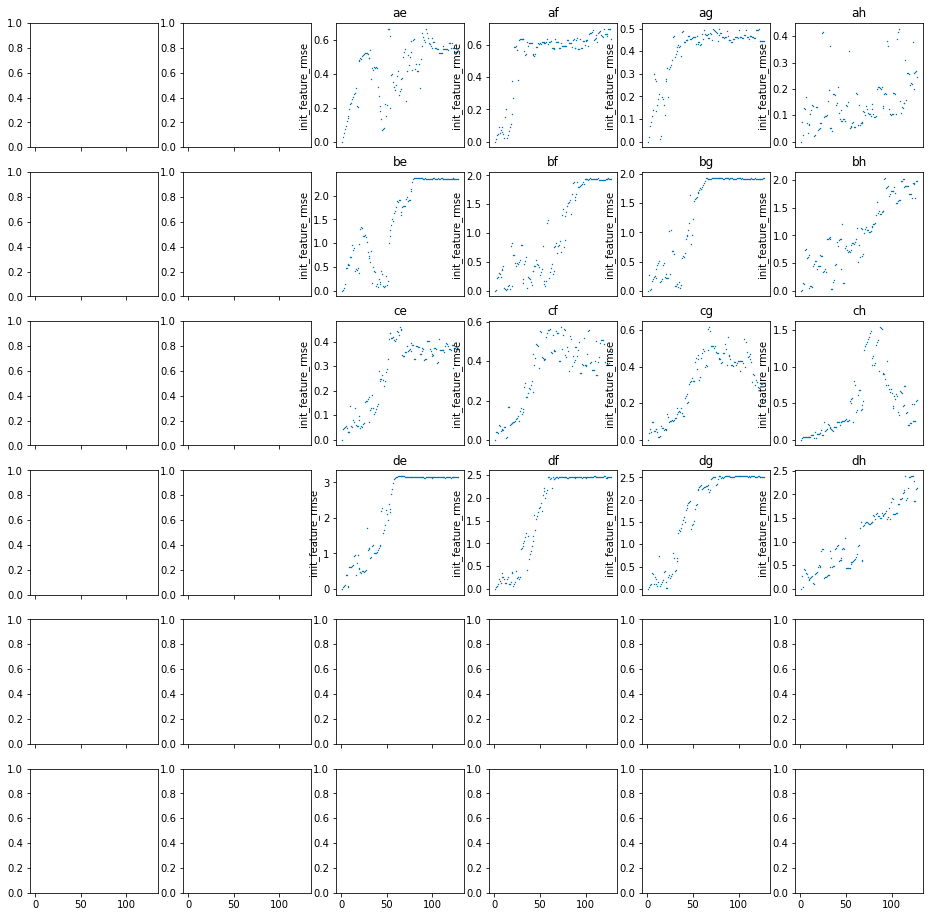

In [47]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)    
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='init_feature_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
#     ax[row][col].get_yaxis().set_visible(False)

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning

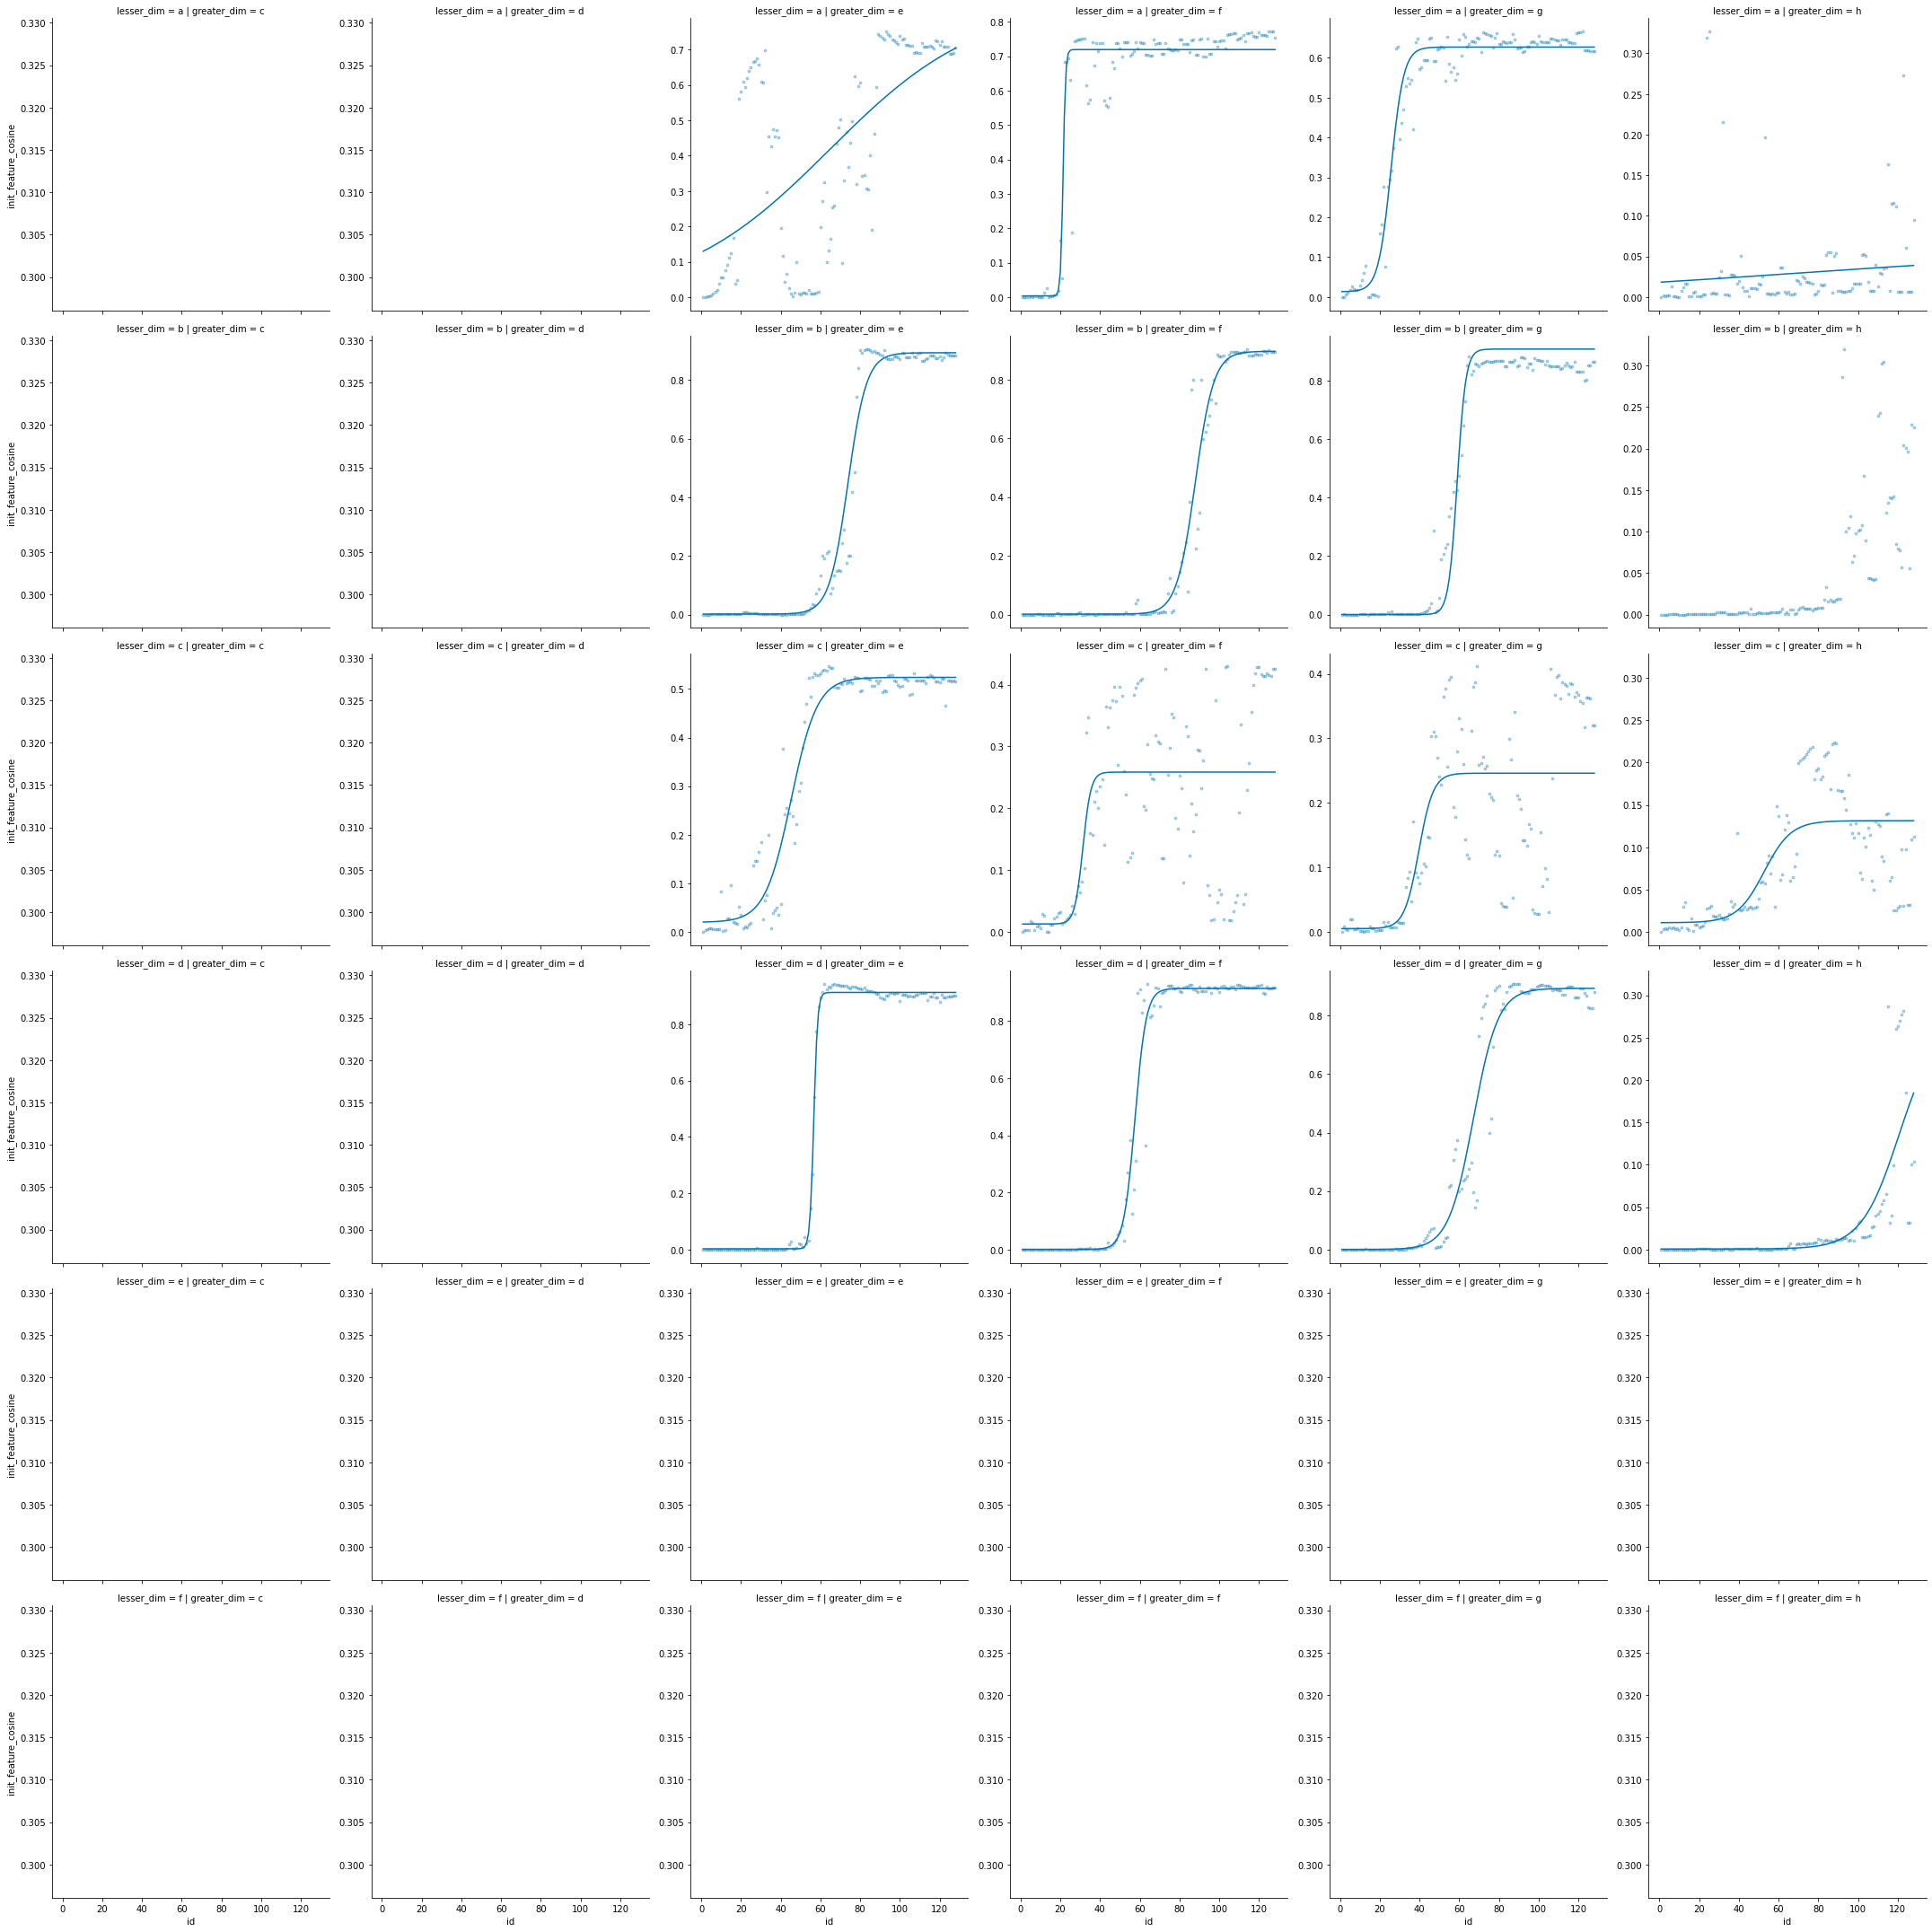

In [50]:
g = sns.lmplot(data=morph_df_sym, 
           x='id', 
           y='init_feature_cosine', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(_4pl, "id", "init_feature_cosine")

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in true_divide
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in true_divide
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow enco

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overf

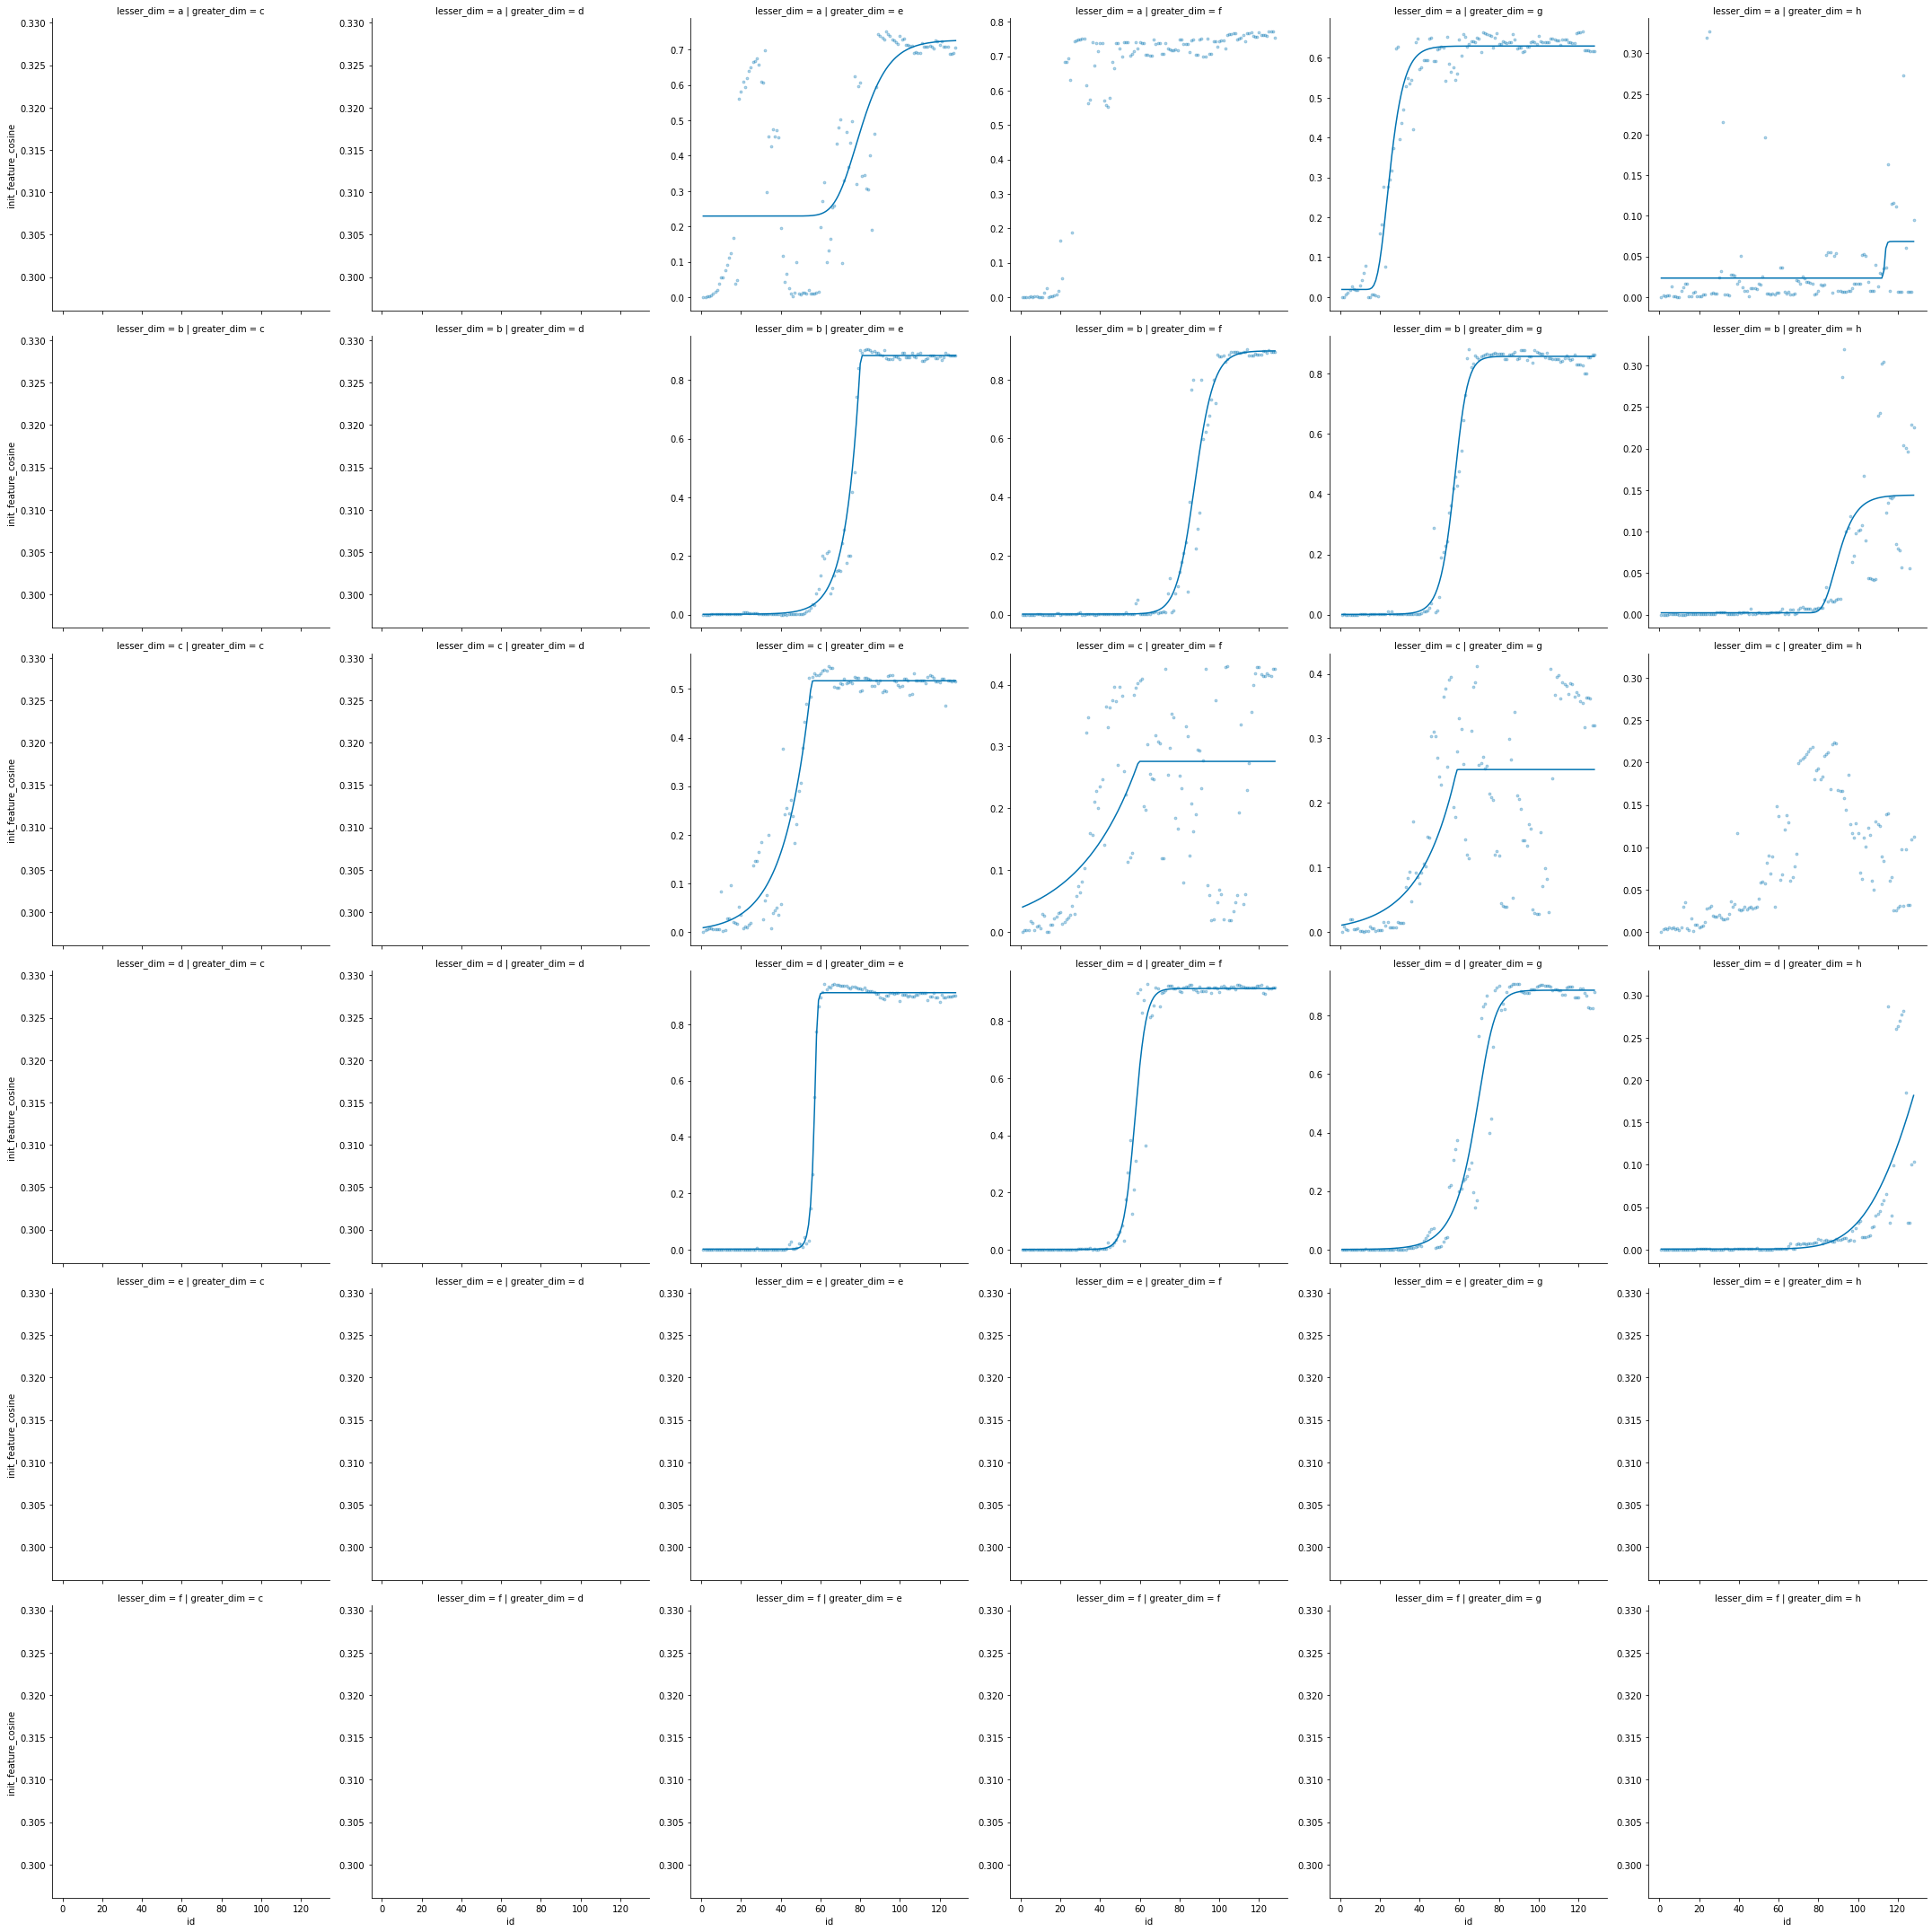

In [51]:
g = sns.lmplot(data=morph_df_sym, 
           x='id', 
           y='init_feature_cosine', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(_5pl, "id", "init_feature_cosine")

In [26]:
group1_frmse = {}
for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    ids = np.array(reduced_morph_df.id.values.tolist())
    loss = np.array(reduced_morph_df.norm_feature_rmse.values.tolist())
    group1_frmse[morph_dim] = fit_4pl(ids, loss)

In [27]:
group1_df_frmse = pd.DataFrame.from_dict(group1_frmse, 
                                            orient='index', 
                                            columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()

In [28]:
group1_df_frmse['group'] = 'Group 1'
group1_df_frmse['metric'] = 'frmse'

group1_df_frmse.head()

,index,min_val,max_val,slope,inflection,group,metric
0,ae,1.417607e-01,1.000000,0.031813,40.330763,Group 1,frmse
1,af,5.910611e-02,0.944703,1.546712,21.026429,Group 1,frmse
2,ag,2.451503e-01,0.894240,0.356684,21.751824,Group 1,frmse
3,ah,1.000000e-16,0.729730,0.008536,81.860142,Group 1,frmse
4,be,2.509878e-01,0.986616,0.165417,60.376306,Group 1,frmse


## feature cosine

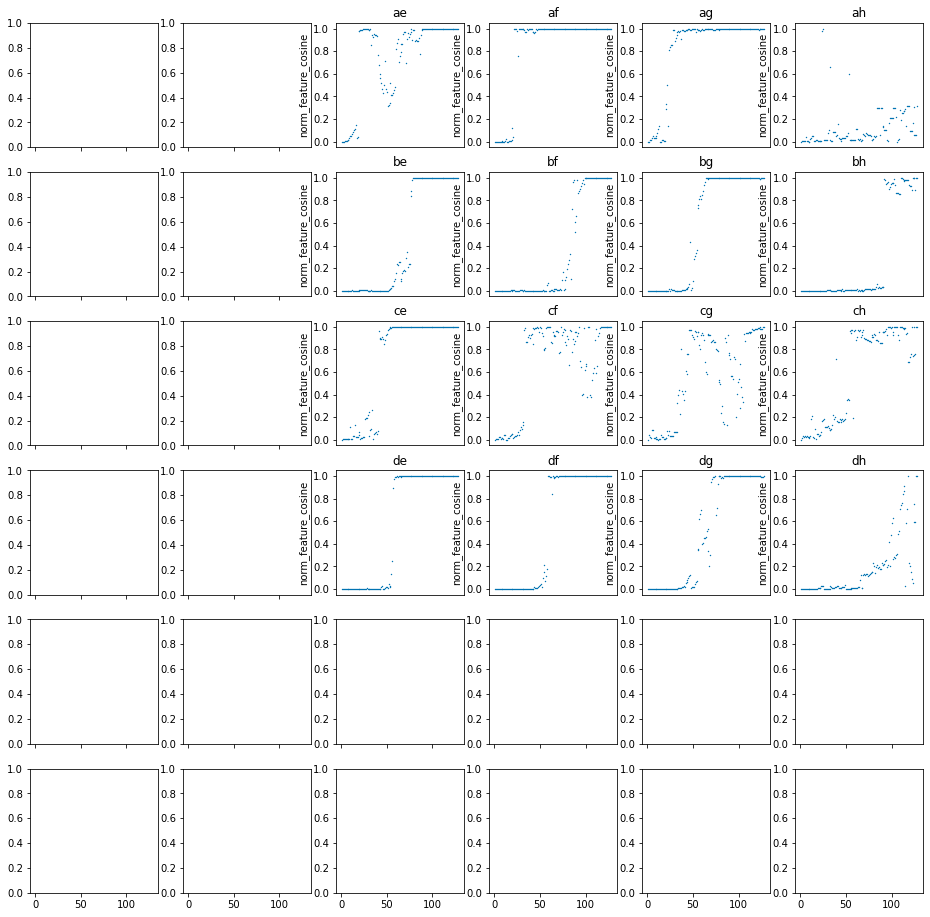

In [77]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='norm_feature_cosine', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
#     ax[row][col].get_yaxis().set_visible(False)


/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square


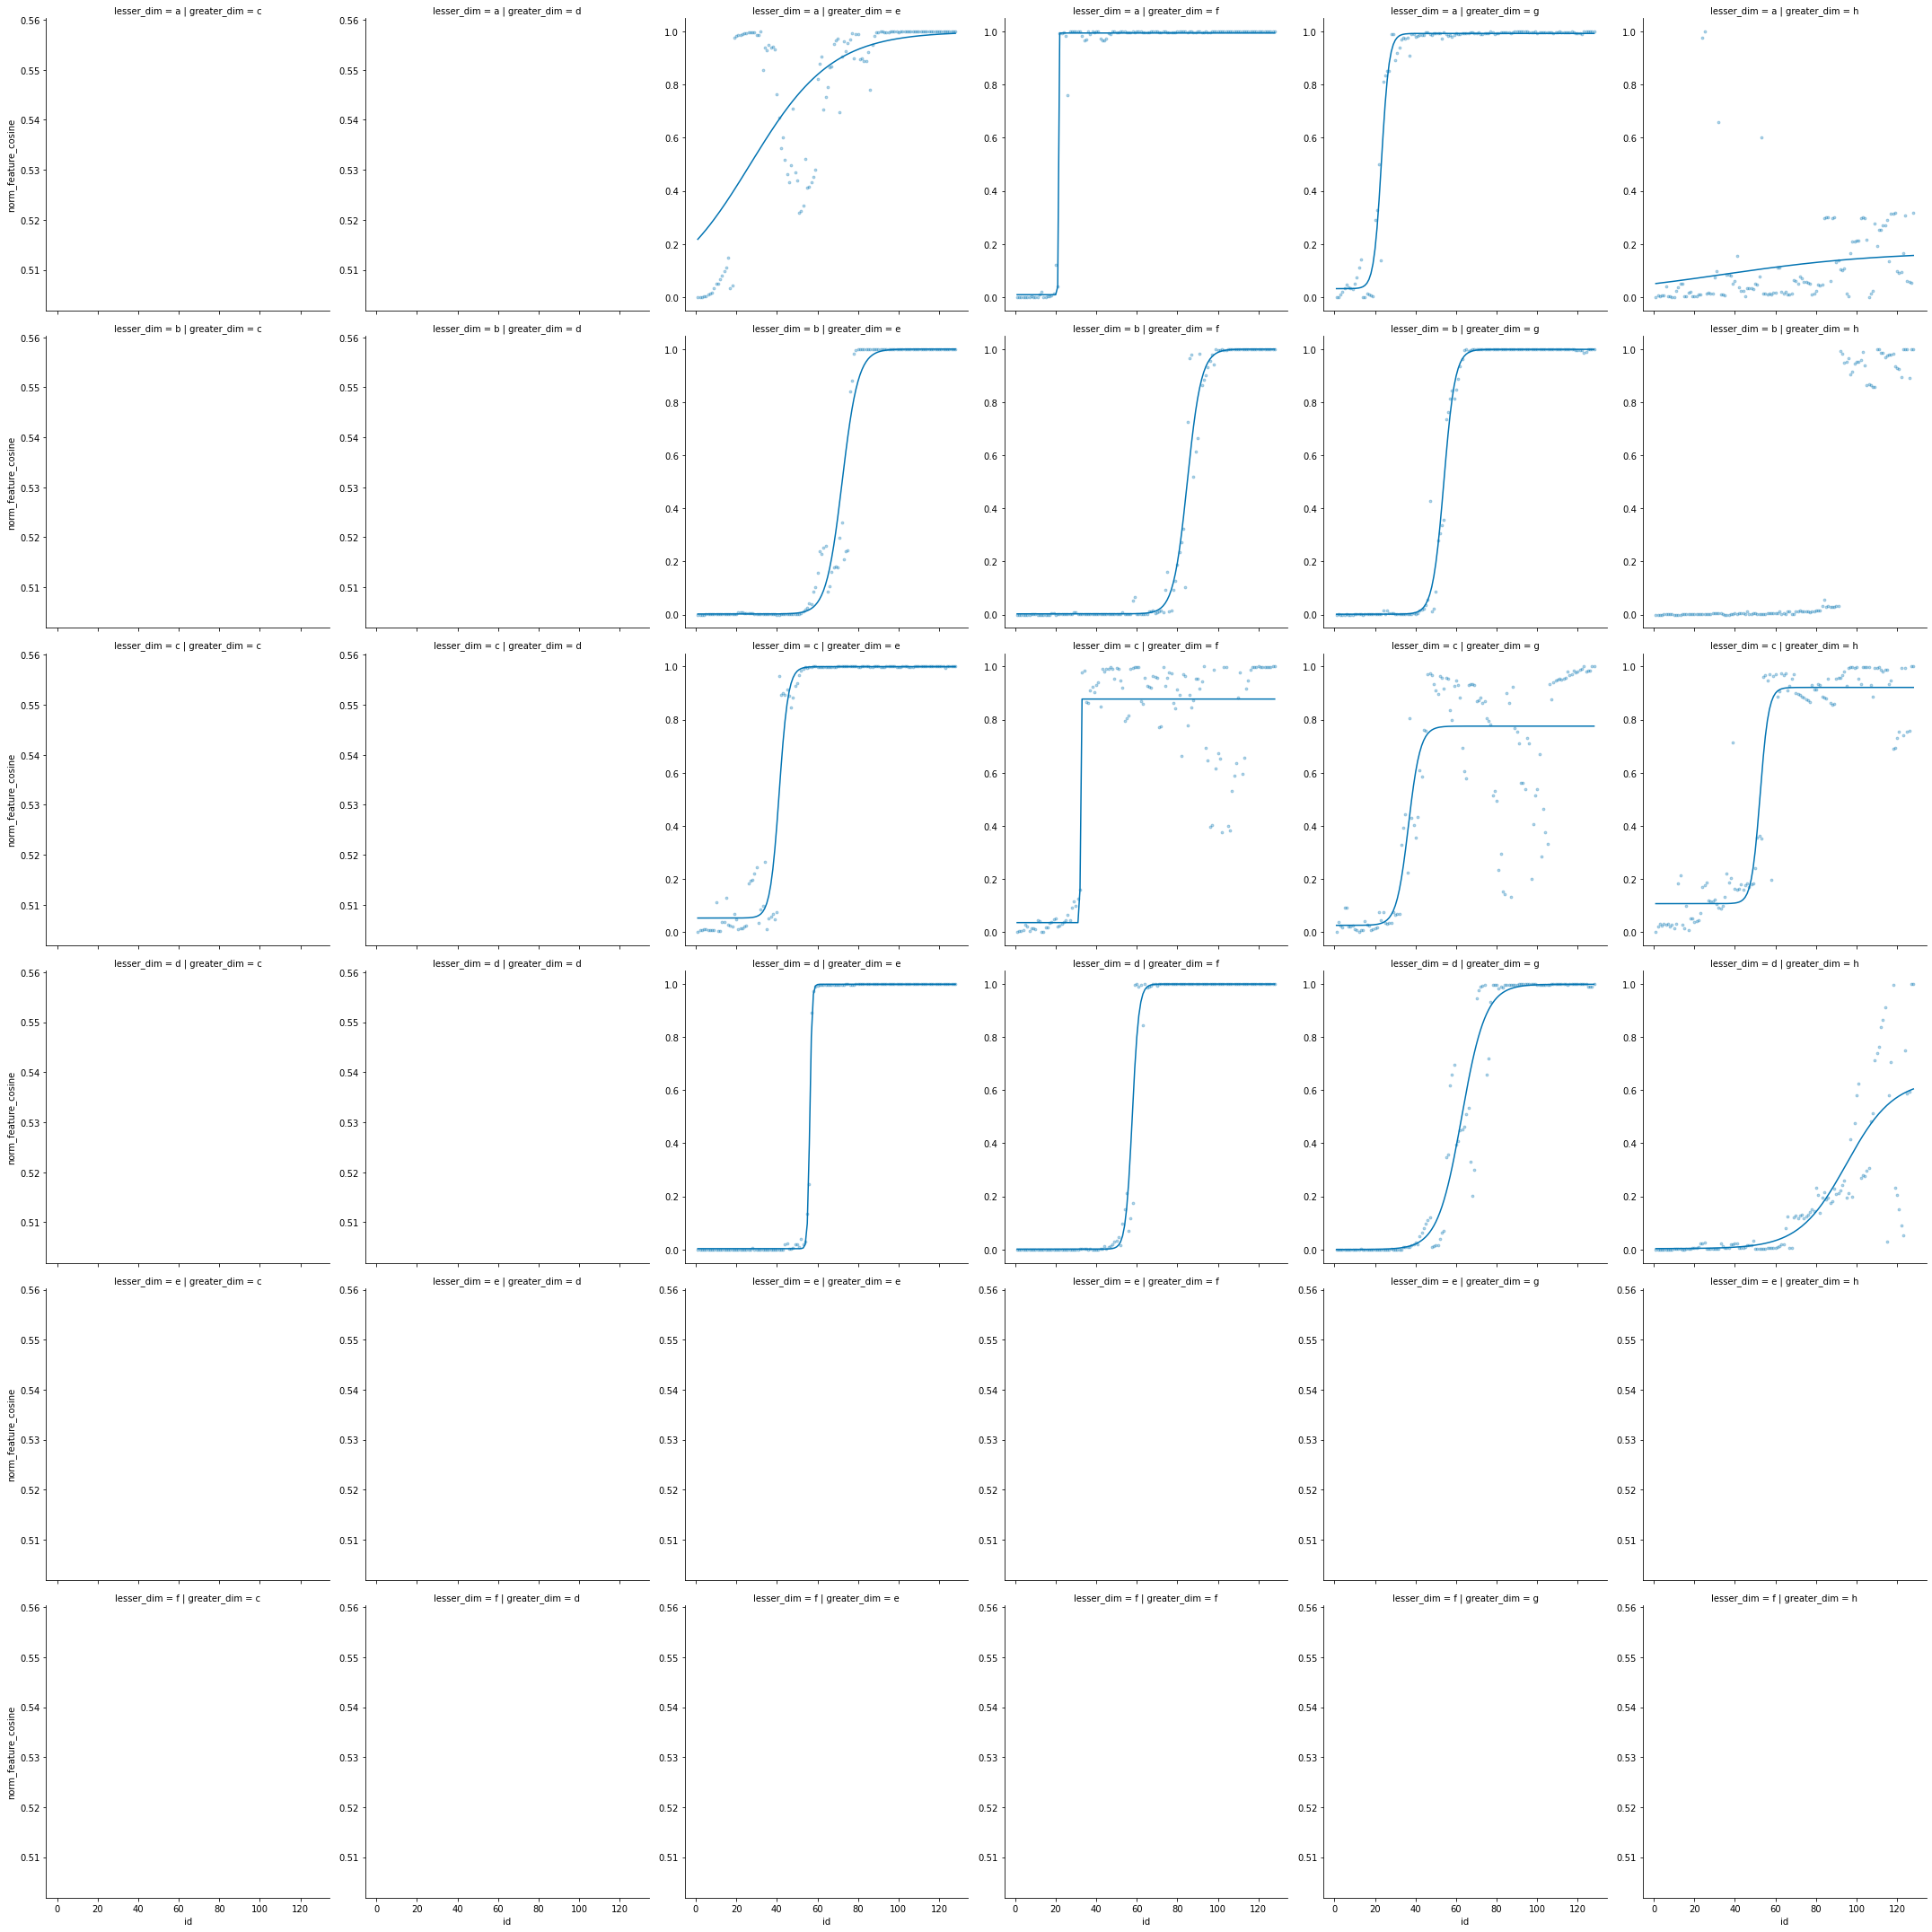

In [117]:
g = sns.lmplot(data=morph_df_sym, 
           x='id', 
           y='norm_feature_cosine', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(_4pl, "id", "norm_feature_cosine")

In [29]:
group1_fcosine = {}
for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    ids = np.array(reduced_morph_df.id.values.tolist())
    loss = np.array(reduced_morph_df.norm_feature_cosine.values.tolist())
    fitted_parameters = fit_4pl(ids, loss)
    if isinstance(fitted_parameters, bool):
        continue
    else:
        group1_fcosine[morph_dim] = fitted_parameters

/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2
/mnt/cube/kai/repositories/star_scale/math_utils.py:397: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:533: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:536: RuntimeWarning: overflow encountered in exp
  temp1 = np.exp(-B * (x - M))
/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: invalid value encountered in true_divide
  temp2 = temp1 / (1.0 + temp1) ** 2


In [30]:
group1_fcosine

{'ae': array([1.00000000e-16, 1.00000000e+00, 4.95040313e-02, 2.68368728e+01]),
 'af': array([9.05570971e-03, 9.94648213e-01, 1.10956097e+01, 2.13121644e+01]),
 'ag': array([ 0.03179335,  0.99298555,  0.53201916, 23.18276119]),
 'ah': array([ 1.71052810e-01,  1.00000000e-16, -2.56255550e-02,  3.43194929e+01]),
 'be': array([2.11133029e-03, 9.99888920e-01, 2.53521266e-01, 7.21981091e+01]),
 'bf': array([2.72310918e-03, 9.99811287e-01, 2.90621342e-01, 8.49325334e+01]),
 'bg': array([1.36162598e-03, 9.98911001e-01, 3.62274322e-01, 5.39446482e+01]),
 'ce': array([ 0.05272478,  0.9995516 ,  0.45165639, 41.15666243]),
 'cf': array([ 0.03544692,  0.87749682, 14.82048159, 32.11751877]),
 'cg': array([2.52317440e-02, 7.75480857e-01, 3.40281173e-01, 3.64688030e+01]),
 'ch': array([ 0.10689657,  0.92129891,  0.47347366, 52.39801778]),
 'de': array([3.11203300e-03, 9.98987917e-01, 1.82656215e+00, 5.62322090e+01]),
 'df': array([1.33126591e-03, 9.99785468e-01, 6.18558089e-01, 5.77626641e+01]),
 'dg

In [31]:
group1_df_fcosine = pd.DataFrame.from_dict(group1_fcosine, 
                                            orient='index', 
                                            columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()

group1_df_fcosine['group'] = 'Group 1'
group1_df_fcosine['metric'] = 'fcosine'

group1_df_fcosine.head()

,index,min_val,max_val,slope,inflection,group,metric
0,ae,1.000000e-16,1.000000e+00,0.049504,26.836873,Group 1,fcosine
1,af,9.055710e-03,9.946482e-01,11.095610,21.312164,Group 1,fcosine
2,ag,3.179335e-02,9.929855e-01,0.532019,23.182761,Group 1,fcosine
3,ah,1.710528e-01,1.000000e-16,-0.025626,34.319493,Group 1,fcosine
4,be,2.111330e-03,9.998889e-01,0.253521,72.198109,Group 1,fcosine


In [32]:
group1_fcombo = {}
for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    ids = np.array(reduced_morph_df.id.values.tolist())
    loss = 0.9*np.array(reduced_morph_df.norm_feature_rmse.values.tolist())+0.1*np.array(reduced_morph_df.norm_spec_rmse.values.tolist())
    fitted_parameters = fit_4pl(ids, loss)
    if isinstance(fitted_parameters, bool):
        continue
    else:
        group1_fcombo[morph_dim] = fitted_parameters

/mnt/cube/kai/repositories/star_scale/math_utils.py:397: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:533: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:536: RuntimeWarning: overflow encountered in exp
  temp1 = np.exp(-B * (x - M))
/mnt/cube/kai/repositories/star_scale/math_utils.py:539: RuntimeWarning: invalid value encountered in true_divide
  temp2 = temp1 / (1.0 + temp1) ** 2


In [33]:
group1_df_combo = pd.DataFrame.from_dict(group1_fcombo, 
                                            orient='index', 
                                            columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()

group1_df_combo['group'] = 'Group 1'
group1_df_combo['metric'] = 'combo'

group1_df_combo.head()

,index,min_val,max_val,slope,inflection,group,metric
0,ae,8.287022e-02,1.000000,0.029554,40.332089,Group 1,combo
1,af,7.283477e-02,0.904971,1.346355,21.075323,Group 1,combo
2,ag,1.872650e-01,0.877223,0.196135,21.408391,Group 1,combo
3,ah,1.000000e-16,0.787592,0.009351,85.464140,Group 1,combo
4,be,1.971653e-01,1.000000,0.085619,58.934168,Group 1,combo


### combine all df

In [5]:
group1_df = pickle.load(open(os.path.join(results_folder, 'group1_predicted.p'), 'rb'))

In [34]:
group1_df = group1_df[group1_df.metric.isin(['frmse', 'fcosine','rmse'])].reset_index(drop=True)

NameError: name 'group1_df' is not defined

In [35]:
group1_df = pd.concat([group1_df_rmse, group1_df_frmse, group1_df_fcosine, group1_df_combo]).reset_index(drop=True)

In [39]:
group1_df[group1_df.metric=='fcosine'].tail()

,index,min_val,max_val,slope,inflection,group,metric
42,ch,1.068966e-01,0.921299,0.473474,52.398018,Group 1,fcosine
43,de,3.112033e-03,0.998988,1.826562,56.232209,Group 1,fcosine
44,df,1.331266e-03,0.999785,0.618558,57.762664,Group 1,fcosine
45,dg,1.000000e-16,0.998902,0.168912,62.735145,Group 1,fcosine
46,dh,3.117956e-03,0.640119,0.085617,94.926209,Group 1,fcosine


In [11]:
group1_df.to_pickle(os.path.join(results_folder, 'group1_predicted.p'))

In [172]:
group1_df = pd.concat([group1_df, 
                       pickle.load(open(os.path.join(results_folder, 'group1_behav.p'), 'rb'))]).reset_index(drop=True)

In [173]:
group1_df[group1_df.metric=='behav']

,index,min_val,max_val,slope,inflection,group,metric
63,ae,0.030521,0.964343,0.121687,51.382570,Group 1,behav
64,af,0.048112,0.952846,0.115358,56.336109,Group 1,behav
65,ag,0.040876,0.950710,0.118767,47.902757,Group 1,behav
66,ah,0.053078,0.957298,0.136680,68.146183,Group 1,behav
67,be,0.039989,0.972752,0.168463,65.885018,Group 1,behav
68,bf,0.039516,0.954389,0.224722,71.203732,Group 1,behav
69,bg,0.039560,0.949381,0.219891,56.433524,Group 1,behav
70,bh,0.042803,0.933531,0.185462,76.172609,Group 1,behav
71,ce,0.061007,0.965692,0.196252,67.871080,Group 1,behav
72,cf,0.050439,0.947891,0.173505,47.273720,Group 1,behav


(0.0, 1.0)

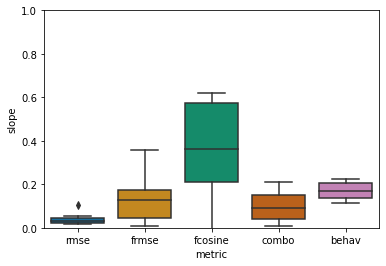

In [174]:
ax = sns.boxplot(y='slope', x='metric',data=group1_df)
ax.set_ylim([0,1])

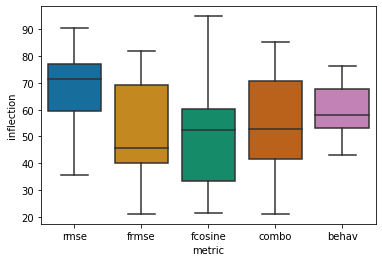

In [175]:
ax = sns.boxplot(y='inflection', x='metric',data=group1_df)
# ax.set_ylim([0,1])

In [176]:
from scipy.stats import ttest_rel

In [177]:
slope_df = group1_df.pivot(index='index',columns='metric',values='slope')

In [178]:
slope_df.dropna(inplace=True)

In [179]:
print(ttest_rel(slope_df['behav'], slope_df['rmse']))

Ttest_relResult(statistic=14.068432233948732, pvalue=1.1850805357850964e-09)


In [180]:
print(ttest_rel(slope_df['behav'], slope_df['frmse']))

Ttest_relResult(statistic=-0.48957263791284444, pvalue=0.6320181876546632)


In [181]:
print(ttest_rel(slope_df['behav'], slope_df['fcosine']))

Ttest_relResult(statistic=-1.6534966420496688, pvalue=0.12046919793521799)


In [182]:
print(ttest_rel(slope_df['behav'], slope_df['combo']))

Ttest_relResult(statistic=-0.13231595005490246, pvalue=0.8966172670616732)


In [183]:
inflection_df = group1_df.pivot(index='index',columns='metric',values='inflection')

In [184]:
inflection_df.dropna(inplace=True)

In [185]:
inflection_df

metric,behav,combo,fcosine,frmse,rmse
index,,,,,
ae,51.382570,40.332089,26.836873,40.330763,76.226299
af,56.336109,21.075323,21.312164,21.026429,58.667611
ag,47.902757,21.408391,23.182761,21.751824,52.000076
ah,68.146183,85.464140,34.319493,81.860142,35.582889
be,65.885018,58.934168,72.198109,60.376306,86.134743
bf,71.203732,76.994751,84.932533,76.803996,90.622292
bg,56.433524,47.248931,53.944648,46.669537,60.408414
ce,67.871080,41.985251,41.156662,41.754844,79.998174
cf,47.273720,74.356395,32.117519,34.754360,76.374947


In [186]:
print(ttest_rel(inflection_df['behav'], inflection_df['rmse']))

Ttest_relResult(statistic=-2.2632084721507897, pvalue=0.040043293230398846)


In [187]:
print(ttest_rel(inflection_df['behav'], inflection_df['frmse']))

Ttest_relResult(statistic=2.0368136803000008, pvalue=0.06103865178268757)


In [188]:
print(ttest_rel(inflection_df['behav'], inflection_df['fcosine']))

Ttest_relResult(statistic=1.6711257672201865, pvalue=0.11689071256620445)


In [189]:
print(ttest_rel(inflection_df['behav'], inflection_df['combo']))

Ttest_relResult(statistic=1.1348129732587344, pvalue=0.2755102203488183)


# Group 2 (ABGH vs CDEF)

In [163]:
group_stim_cats = generate_stim_combos('abgh', 'cdef')

In [80]:
weights_file = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group2/weights-improvement.h5')
feature_extractor.load_weights(weights_file, by_name=True)

In [81]:
cat_list = []
id_list = []
feature_rmse_list_init = []
feature_cosine_list_init = []
spec_rmse_list_init = []
feature_rmse_list_final = []
feature_cosine_list_final = []
spec_rmse_list_final = []
less_dim_list = []
more_dim_list = []

feature_rmse_list_comb = []
feature_cosine_list_comb = []
spec_rmse_list_comb = []

feature_rmse_list_norm = []
feature_cosine_list_norm = []
spec_rmse_list_norm = []


for cat in group_stim_cats:
    cat_specs = spec_df[spec_df.stim==cat].reset_index(drop=True)
    
    # cat lists
    feature_rmse_list_init_cat = []
    feature_cosine_list_init_cat = []
    spec_rmse_list_init_cat = []
    
    feature_rmse_list_final_cat = []
    feature_cosine_list_final_cat = []
    spec_rmse_list_final_cat = []
    
    # init value
    init_spec = cat_specs[cat_specs.id==1].spec.values[0]
    init_spec_3d = np.stack([init_spec, init_spec, init_spec], axis = 2)
    init_features = np.squeeze(feature_extractor.predict(np.expand_dims(init_spec_3d, axis=0)))
    
    # last value
    final_spec = cat_specs[cat_specs.id==128].spec.values[0]
    final_spec_3d = np.stack([final_spec, final_spec, final_spec], axis = 2)
    final_features = np.squeeze(feature_extractor.predict(np.expand_dims(final_spec_3d, axis=0)))
    
    # diff
    max_feature_rmse = rmse(init_features, final_features)
    max_feature_cosine = distance.cosine(init_features, final_features)
    max_spec_rmse = rmse(init_spec_3d, final_spec_3d)
    
    # iterate through morphs
    for _, spec_i, _, spec in cat_specs.values:
        spec_3d = np.stack([spec, spec, spec], axis = 2)

        spec_features = np.squeeze(feature_extractor.predict(np.expand_dims(spec_3d, axis=0)))
        
        init_feature_rmse = rmse(init_features, spec_features)
        final_feature_rmse = rmse(final_features, spec_features)
        init_feature_cosine = distance.cosine(init_features, spec_features)
        final_feature_cosine = distance.cosine(final_features, spec_features)
        init_spec_rmse = rmse(init_spec_3d, spec_3d)
        final_spec_rmse = rmse(final_spec_3d, spec_3d)
        
#         if init_feature_rmse>final_feature_rmse:
#             feature_rmse = max_feature_rmse-final_feature_rmse
#         else:
#             feature_rmse = init_feature_rmse
        
#         if init_feature_cosine>final_feature_cosine:
#             feature_cosine = max_feature_cosine-final_feature_cosine
#         else:
#             feature_cosine = init_feature_cosine
        
#         if init_spec_rmse>final_spec_rmse:
#             spec_rmse = max_spec_rmse-final_spec_rmse
#         else:
#             spec_rmse = init_spec_rmse

#         feature_cosine = (max_feature_cosine-final_feature_cosine+init_feature_cosine)/2
#         feature_rmse = (max_feature_rmse-final_feature_rmse+init_feature_rmse)/2
#         spec_rmse = (max_spec_rmse-final_spec_rmse+init_spec_rmse)/2

#         spec_rmse = distance_to_confidence(spec_3d, init_spec_3d, final_spec_3d, rmse)
#         feature_rmse = distance_to_confidence(spec_features, init_features, final_features, rmse)
#         feature_cosine = distance_to_confidence(spec_features, init_features, final_features, distance.cosine)
#         spec_rmse = avrg_distance(spec_3d, init_spec_3d, final_spec_3d, rmse)
#         feature_rmse = avrg_distance(spec_features, init_features, final_features, rmse)
#         feature_cosine = avrg_distance(spec_features, init_features, final_features, distance.cosine)
        
        
        cat_list.append(cat)
        less_dim_list.append(cat[0])
        more_dim_list.append(cat[1])
        id_list.append(spec_i)
        
#         feature_rmse_list.append(feature_rmse)
#         feature_cosine_list.append(feature_cosine)
#         spec_rmse_list.append(spec_rmse)
        feature_rmse_list_init_cat.append(init_feature_rmse)
        feature_rmse_list_final_cat.append(final_feature_rmse)
        feature_cosine_list_init_cat.append(init_feature_cosine)
        feature_cosine_list_final_cat.append(final_feature_cosine)
        spec_rmse_list_init_cat.append(init_spec_rmse)
        spec_rmse_list_final_cat.append(final_spec_rmse)
        
    feature_rmse_list_init += feature_rmse_list_init_cat
    feature_rmse_list_final += feature_rmse_list_final_cat
    feature_cosine_list_init += feature_cosine_list_init_cat
    feature_cosine_list_final += feature_cosine_list_final_cat
    spec_rmse_list_init += spec_rmse_list_init_cat
    spec_rmse_list_final += spec_rmse_list_final_cat
    
    feature_rmse_list_comb_cat = flip_at_peak(feature_rmse_list_init_cat, feature_rmse_list_final_cat)
    feature_cosine_list_comb_cat = flip_at_peak(feature_cosine_list_init_cat, feature_cosine_list_final_cat)
    spec_rmse_list_comb_cat = flip_at_peak(spec_rmse_list_init_cat, spec_rmse_list_final_cat, monotonous=True)
    
    feature_rmse_list_comb += feature_rmse_list_comb_cat
    feature_cosine_list_comb += feature_cosine_list_comb_cat
    spec_rmse_list_comb += spec_rmse_list_comb_cat
    
    feature_rmse_list_norm += list(np.abs(feature_rmse_list_comb_cat)/np.max(feature_rmse_list_comb_cat))
    feature_cosine_list_norm += list(np.abs(feature_cosine_list_comb_cat)/np.max(feature_cosine_list_comb_cat))
    spec_rmse_list_norm += list(np.abs(spec_rmse_list_comb_cat)/np.max(spec_rmse_list_comb_cat))
    
    paragraph_print(f'Done with {cat}', separation='*')

Done with ac
**************************************************
Done with ad
**************************************************
Done with ae
**************************************************
Done with af
**************************************************
Done with bc
**************************************************
Done with bd
**************************************************
Done with be
**************************************************
Done with bf
**************************************************
Done with cg
**************************************************
Done with dg
**************************************************
Done with eg
**************************************************
Done with fg
**************************************************
Done with ch
**************************************************
Done with dh
**************************************************
Done with eh
**************************************************
Done with fh
***************************

In [82]:
morph_df_sym = pd.DataFrame()
morph_df_sym['morph_dim'] = cat_list
morph_df_sym['id'] = id_list

morph_df_sym['lesser_dim'] = less_dim_list
morph_df_sym['greater_dim'] = more_dim_list
morph_df_sym['init_feature_rmse'] = feature_rmse_list_init
morph_df_sym['final_feature_rmse'] = feature_rmse_list_final
morph_df_sym['init_feature_cosine'] = feature_cosine_list_init
morph_df_sym['final_feature_cosine'] = feature_cosine_list_final
morph_df_sym['init_spec_rmse'] = spec_rmse_list_init
morph_df_sym['final_spec_rmse'] = spec_rmse_list_final

morph_df_sym['comb_feature_rmse'] = feature_rmse_list_comb
morph_df_sym['comb_feature_cosine'] = feature_cosine_list_comb
morph_df_sym['comb_spec_rmse'] = spec_rmse_list_comb

morph_df_sym['norm_feature_rmse'] = feature_rmse_list_norm
morph_df_sym['norm_feature_cosine'] = feature_cosine_list_norm
morph_df_sym['norm_spec_rmse'] = spec_rmse_list_norm

In [83]:
morph_df_sym.to_pickle(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group2', 
                                    'morph_comb.p'))

In [164]:
morph_df_sym = pickle.load(open(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group2', 
                                             'morph_comb.p'), 'rb'))

## RMSE

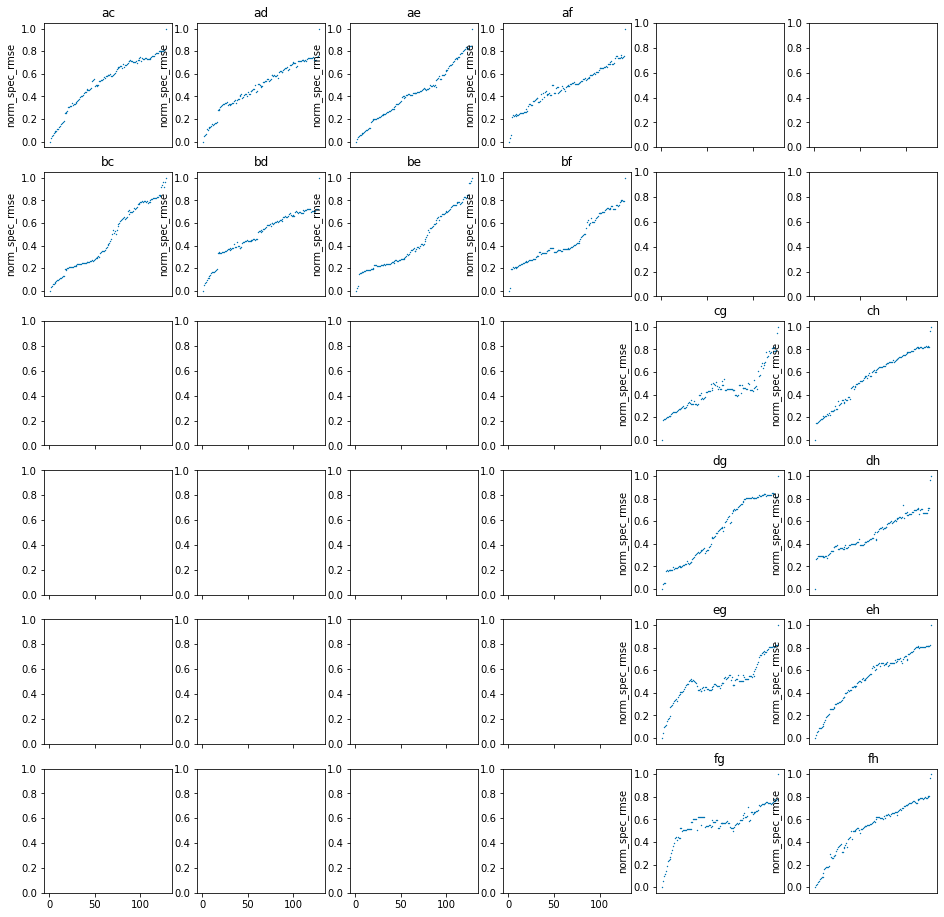

In [85]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='norm_spec_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
#     ax[row][col].get_yaxis().set_visible(False)

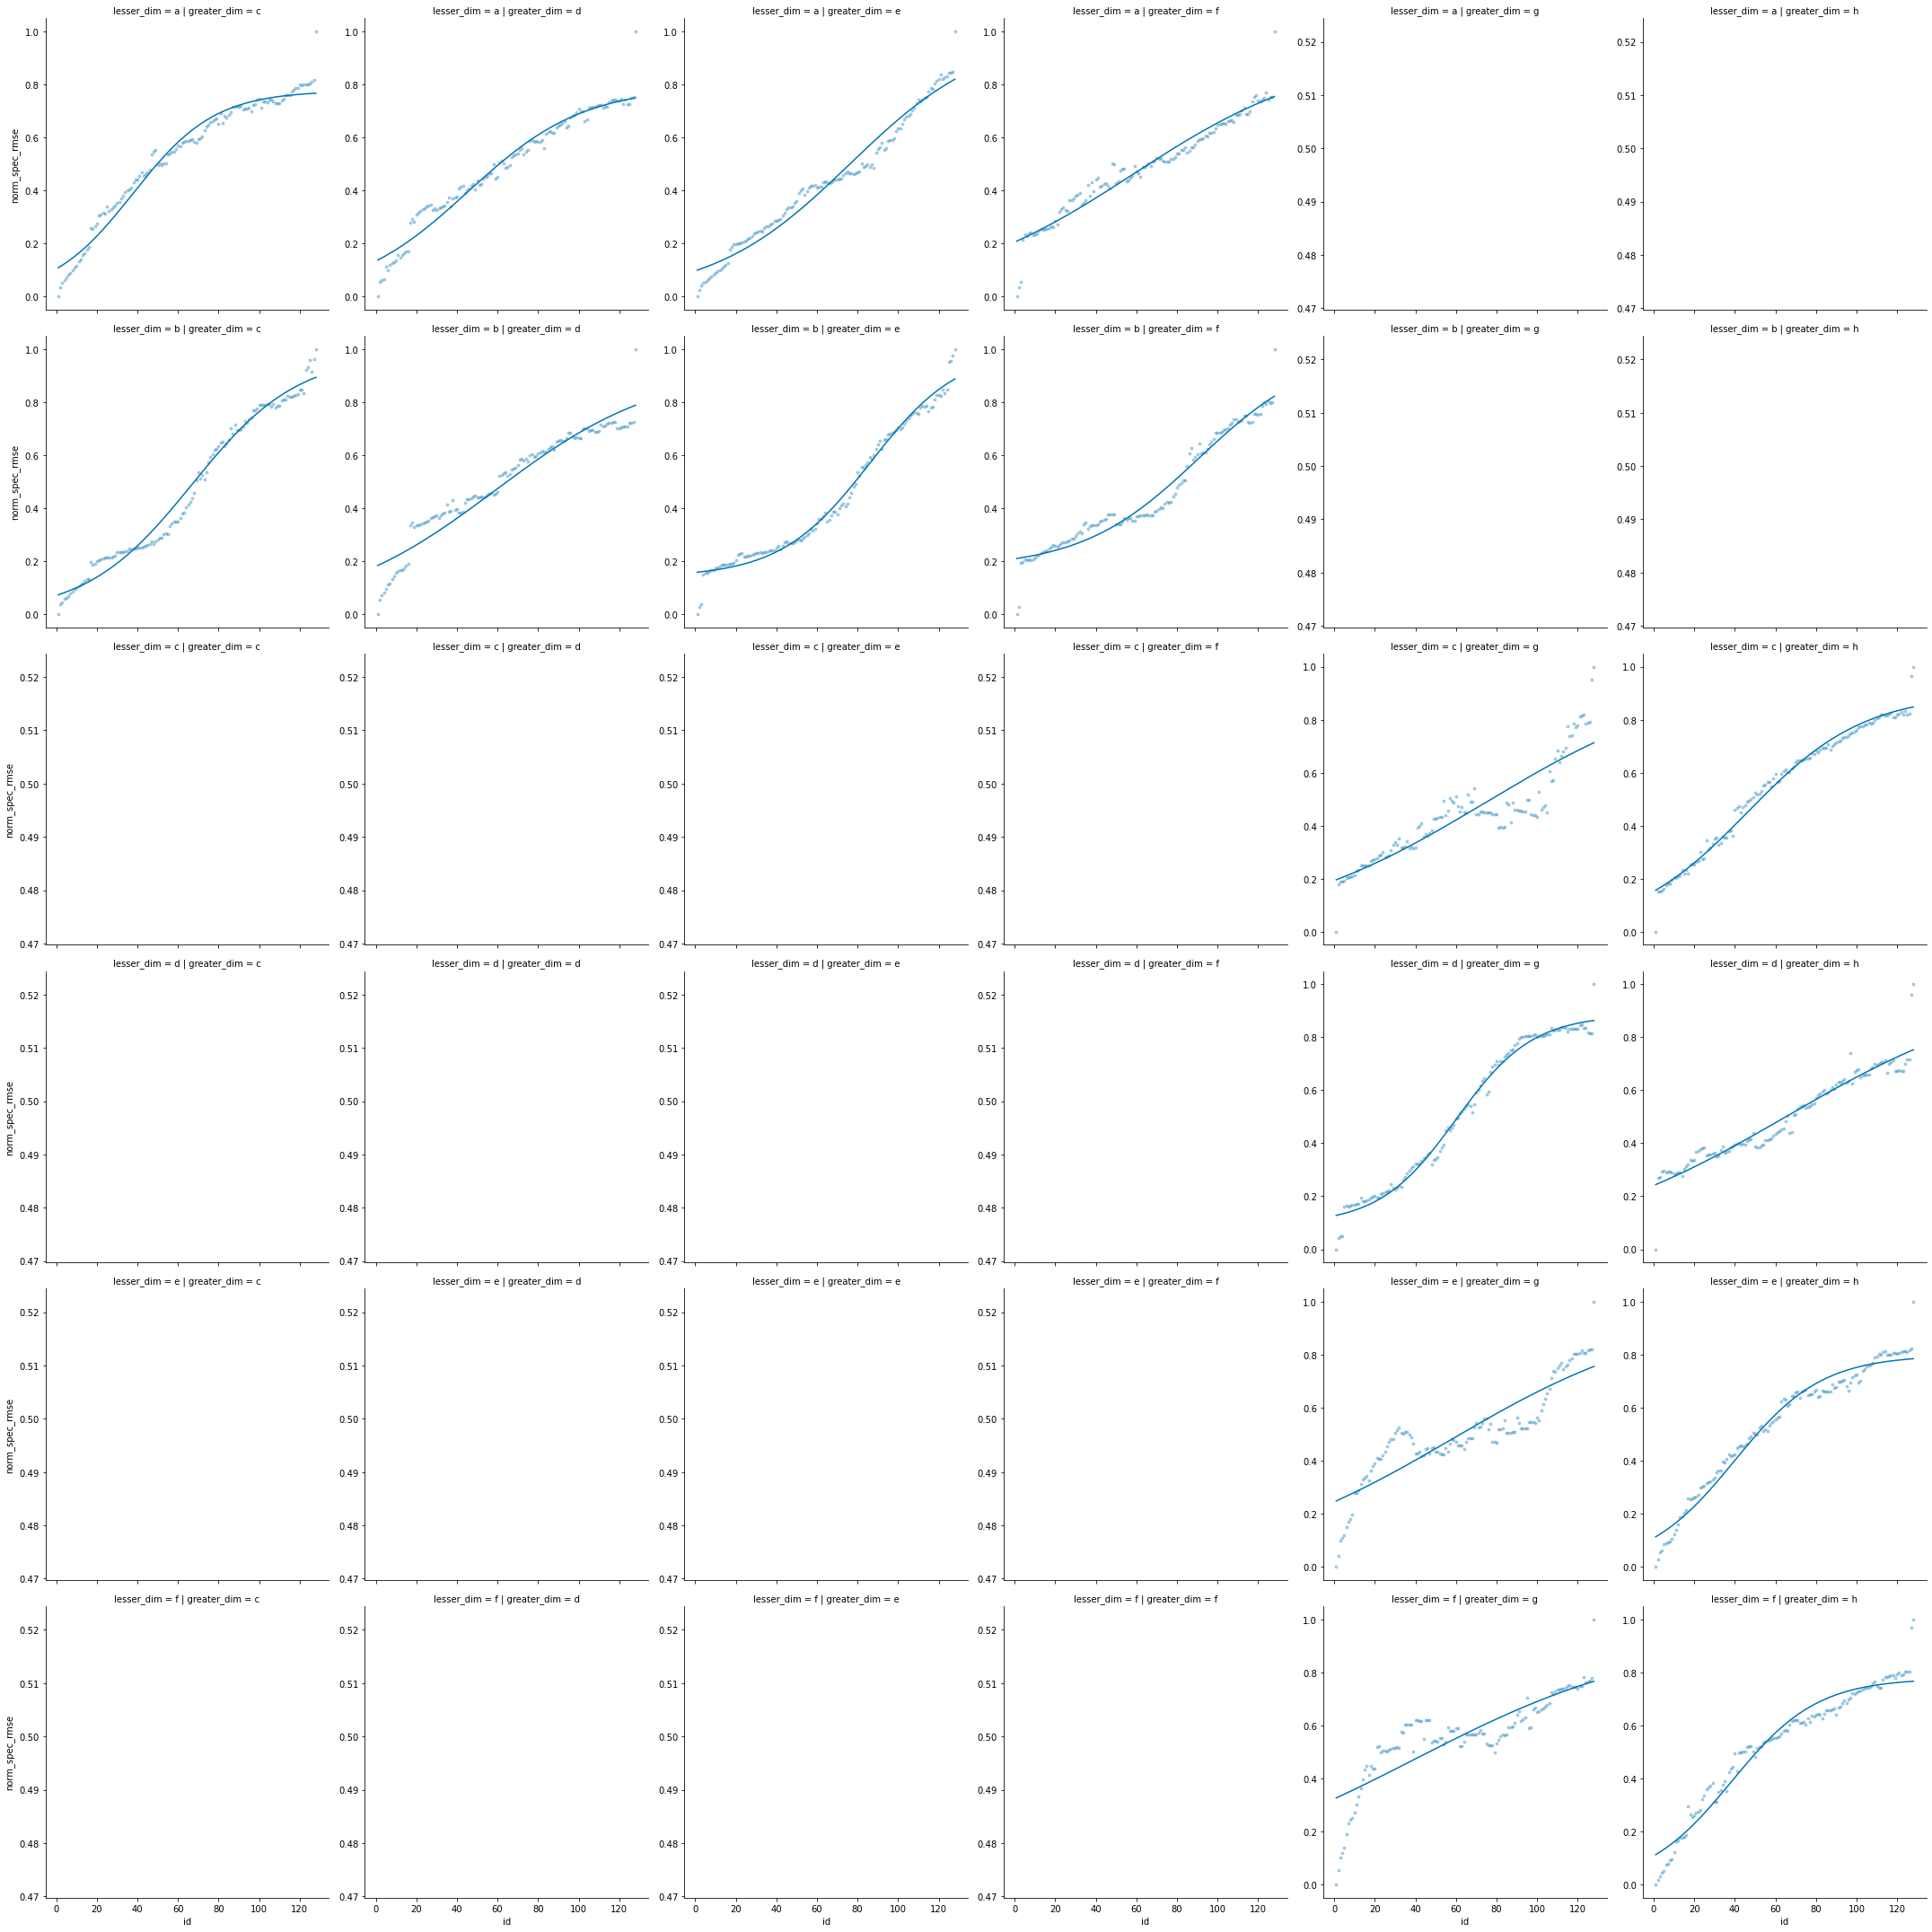

In [120]:
g = sns.lmplot(data=morph_df_sym, 
           x='id', 
           y='norm_spec_rmse', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(_4pl, "id", "norm_spec_rmse")

## feature RMSE

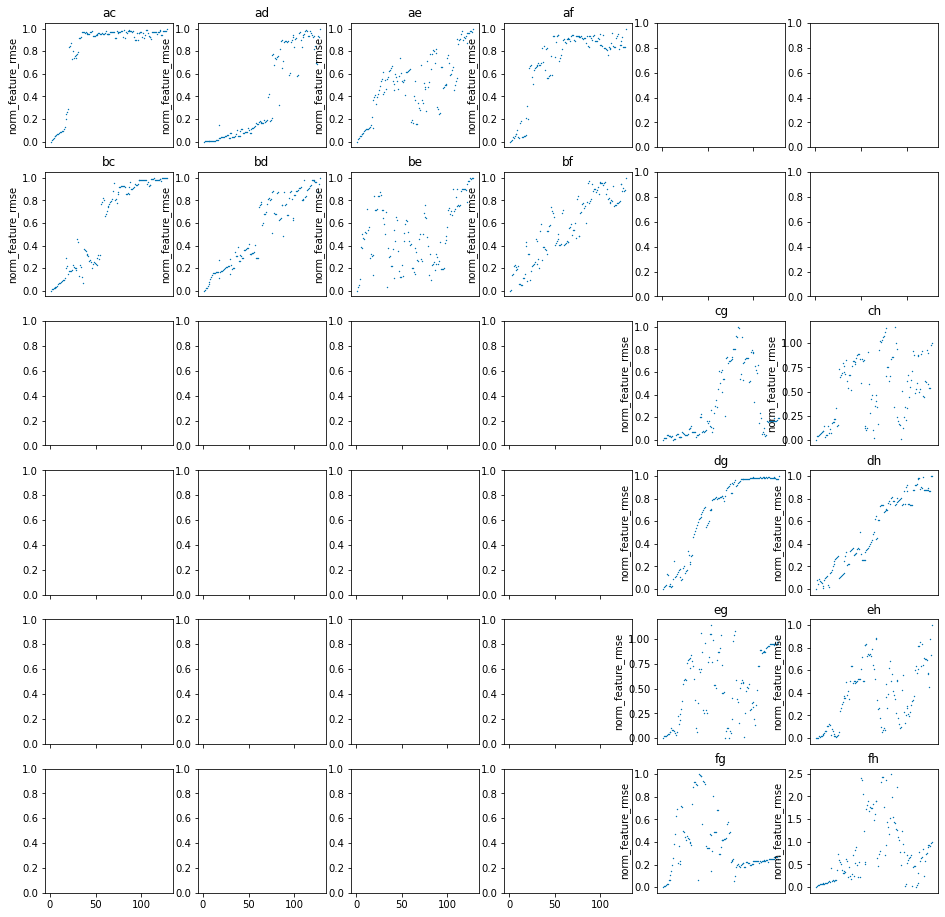

In [86]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)    
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='norm_feature_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
#     ax[row][col].get_yaxis().set_visible(False)

## feature cosine

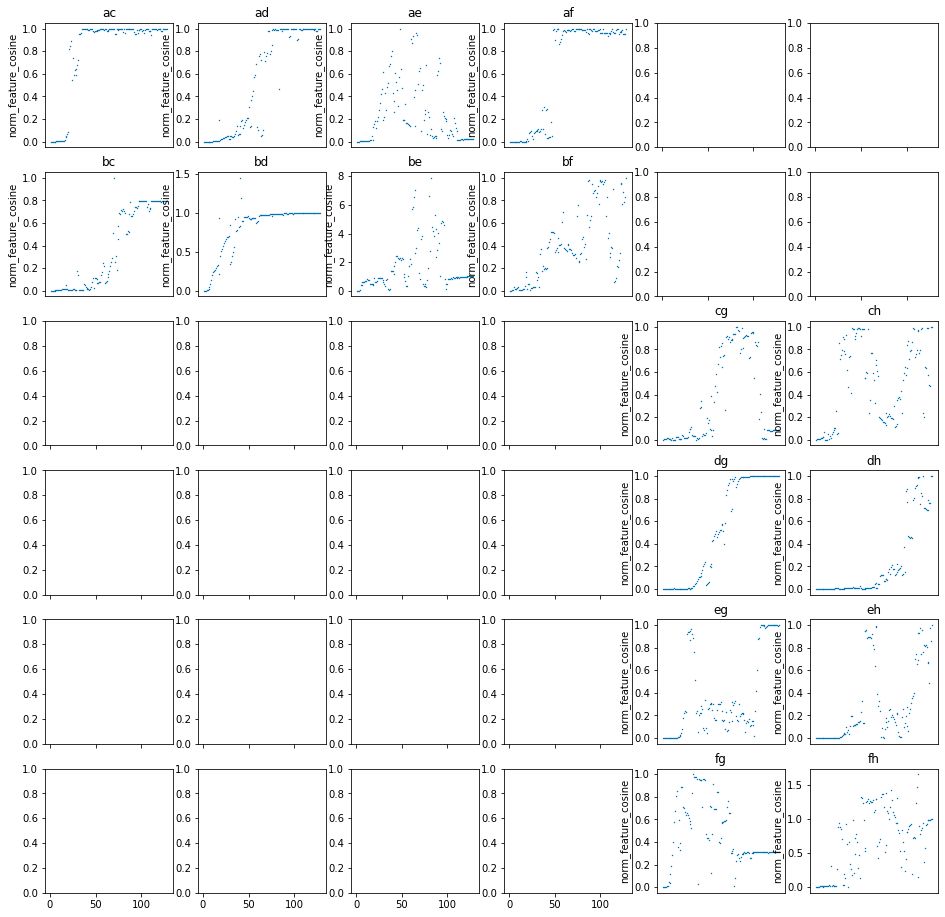

In [87]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='norm_feature_cosine', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
#     ax[row][col].get_yaxis().set_visible(False)


/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/

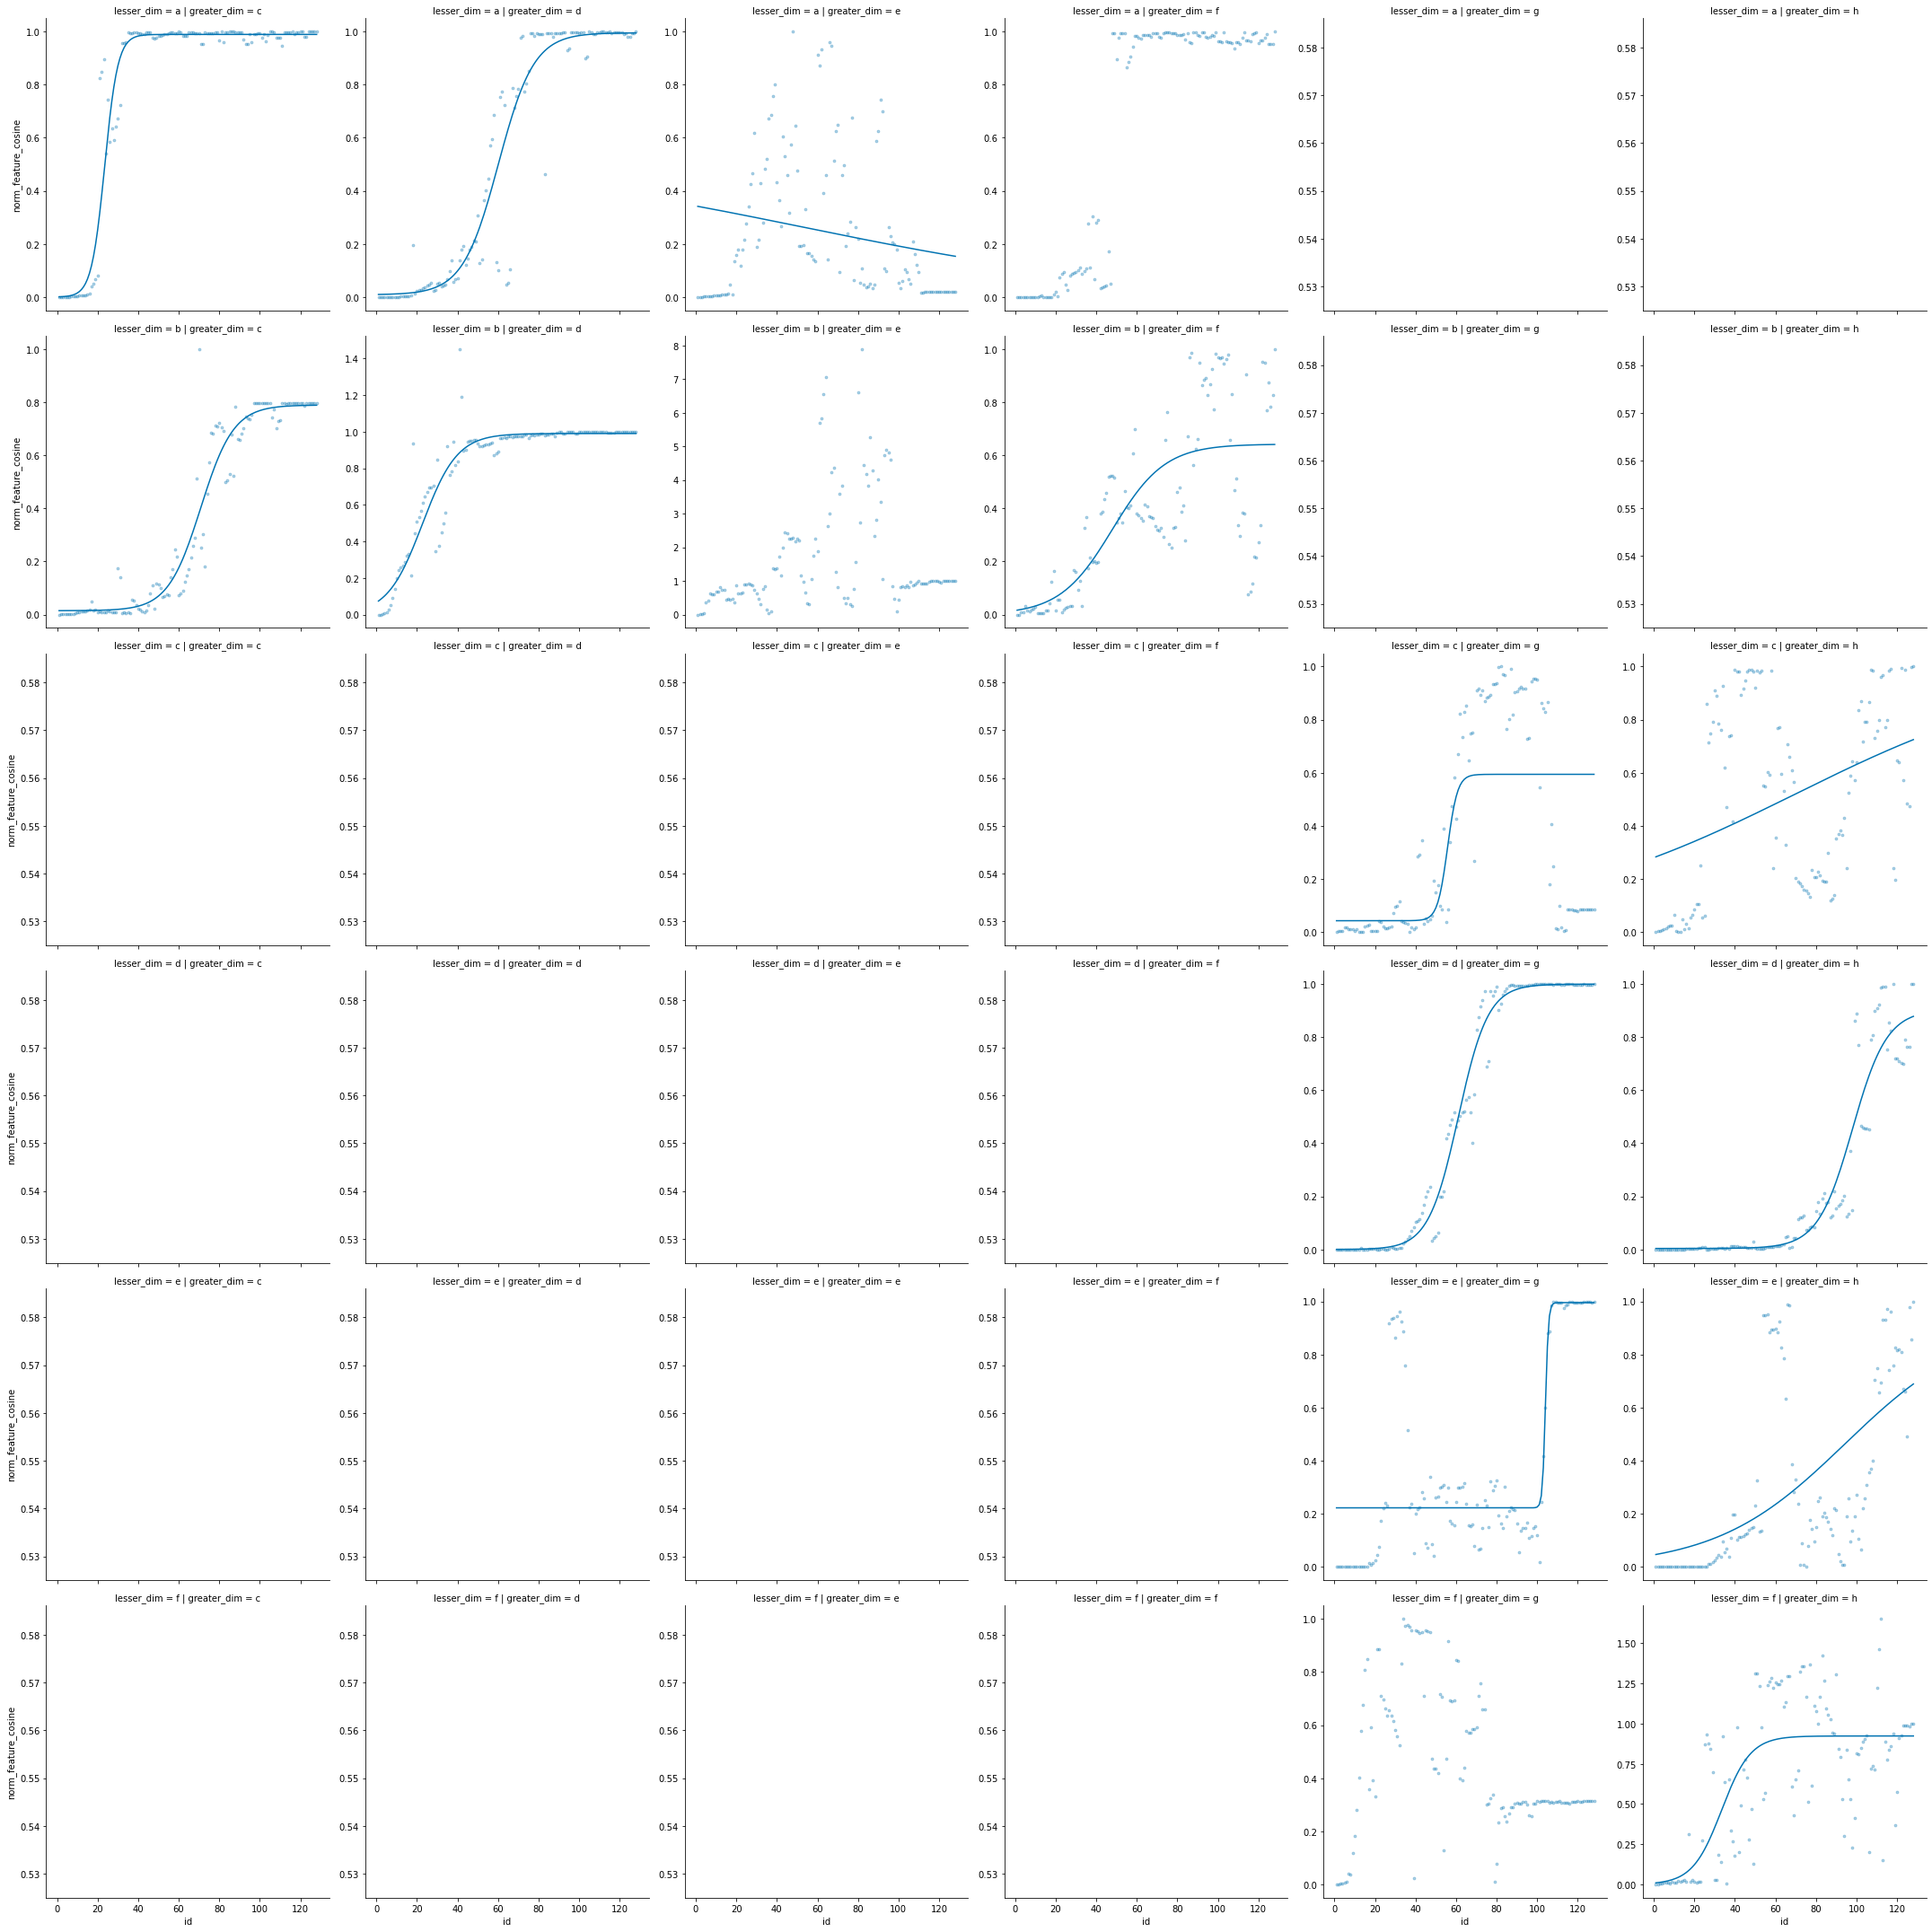

In [122]:
g = sns.lmplot(data=morph_df_sym, 
           x='id', 
           y='norm_feature_cosine', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(_4pl, "id", "norm_feature_cosine")

## analyze accuracy vs behavior

In [166]:
group2_fcosine = {}
group2_frmse = {}
group2_rmse = {}
group2_combo = {}

for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    ids = np.array(reduced_morph_df.id.values.tolist())
    fcosine_l = np.array(reduced_morph_df.norm_feature_cosine.values.tolist())
    frmse_l = np.array(reduced_morph_df.norm_feature_rmse.values.tolist())
    rmse_l = np.array(reduced_morph_df.norm_spec_rmse.values.tolist())
    combo_l = 0.1*np.array(reduced_morph_df.norm_spec_rmse.values.tolist())+0.9*np.array(reduced_morph_df.norm_feature_rmse.values.tolist())
    fcosine_p = fit_4pl(ids, fcosine_l)
    frmse_p = fit_4pl(ids, frmse_l)
    rmse_p = fit_4pl(ids, rmse_l)
    combo_p = fit_4pl(ids, combo_l)
    
    if isinstance(fcosine_p, bool) or isinstance(frmse_p, bool) or isinstance(rmse_p, bool):
        continue
    else:
        group2_fcosine[morph_dim] = fcosine_p
        group2_frmse[morph_dim] = frmse_p
        group2_rmse[morph_dim] = rmse_p
        group2_combo[morph_dim] = combo_p

In [168]:
group2_df_combo = pd.DataFrame.from_dict(group2_combo, 
                                            orient='index', 
                                            columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()
group2_df_rmse = pd.DataFrame.from_dict(group2_rmse, 
                                            orient='index', 
                                            columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()
group2_df_frmse = pd.DataFrame.from_dict(group2_frmse, 
                                            orient='index', 
                                            columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()
group2_df_fcosine = pd.DataFrame.from_dict(group2_fcosine, 
                                            orient='index', 
                                            columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()

group2_df_combo['group'] = 'Group 2'
group2_df_rmse['group'] = 'Group 2'
group2_df_frmse['group'] = 'Group 2'
group2_df_fcosine['group'] = 'Group 2'

group2_df_combo['metric'] = 'combo'
group2_df_rmse['metric'] = 'rmse'
group2_df_frmse['metric'] = 'frmse'
group2_df_fcosine['metric'] = 'fcosine'

group2_df = pd.concat([group2_df_rmse, group2_df_frmse, group2_df_fcosine, group2_df_combo]).reset_index(drop=True)

In [13]:
group2_df.tail()

,index,min_val,max_val,slope,inflection,group,metric
31,dg,1.000000e-16,0.999431,0.136132,61.099803,Group 2,fcosine
32,eg,2.226526e-01,0.995659,1.357777,104.038983,Group 2,fcosine
33,ch,3.827235e-02,1.000000,0.015650,69.624772,Group 2,fcosine
34,dh,3.843306e-03,0.903529,0.117663,97.955144,Group 2,fcosine
35,eh,1.000000e-16,0.928440,0.031418,94.335911,Group 2,fcosine


In [14]:
group2_df.to_pickle(os.path.join(results_folder, 'group2_predicted.p'))

In [12]:
group2_df = pickle.load(open(os.path.join(results_folder, 'group2_predicted.p'), 'rb'))
group2_df = group2_df[group2_df.metric.isin(['frmse', 'fcosine','rmse'])].reset_index(drop=True)

In [192]:
group2_df = pd.concat([group2_df, 
                       pickle.load(open(os.path.join(results_folder, 'group2_behav.p'), 'rb'))]).reset_index(drop=True)

(0.0, 1.0)

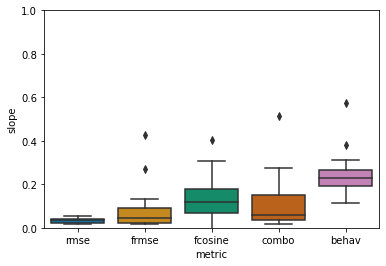

In [195]:
ax = sns.boxplot(y='slope', x='metric',data=group2_df)
ax.set_ylim([0,1])

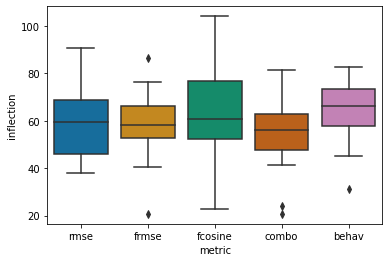

In [196]:
ax = sns.boxplot(y='inflection', x='metric',data=group2_df)
# ax.set_ylim([0,1])

In [197]:
from scipy.stats import ttest_rel

In [198]:
slope_df = group2_df.pivot(index='index',columns='metric',values='slope')

In [199]:
slope_df.dropna(inplace=True)

In [200]:
print(ttest_rel(slope_df['behav'], slope_df['rmse']))

Ttest_relResult(statistic=11.384131306692675, pvalue=1.9954763256238628e-07)


In [201]:
print(ttest_rel(slope_df['behav'], slope_df['frmse']))

Ttest_relResult(statistic=3.720310029357906, pvalue=0.0033799550158480113)


In [202]:
print(ttest_rel(slope_df['behav'], slope_df['fcosine']))

Ttest_relResult(statistic=0.09617267891929973, pvalue=0.9251132048664094)


In [203]:
print(ttest_rel(slope_df['behav'], slope_df['combo']))

Ttest_relResult(statistic=2.3321040510893885, pvalue=0.03972147992757221)


In [204]:
inflection_df = group2_df.pivot(index='index',columns='metric',values='inflection')

In [205]:
inflection_df.dropna(inplace=True)

In [206]:
inflection_df

metric,behav,combo,fcosine,frmse,rmse
index,,,,,
ac,68.706434,20.834715,23.487673,20.673052,37.757563
ad,66.375064,74.542932,60.177889,74.881876,45.444632
ae,82.727900,62.571818,53.749790,62.642776,76.226299
bc,68.142208,53.998572,70.840806,53.997700,67.000628
bd,72.487040,56.282956,22.663730,57.549625,59.000542
bf,77.380937,49.845723,47.987967,48.261078,90.622292
cg,62.498651,56.160350,55.760690,57.145629,74.500486
ch,59.955240,24.080986,69.624772,86.595444,46.001759
dg,53.999948,41.113731,61.099803,40.403984,59.998245


In [207]:
print(ttest_rel(inflection_df['behav'], inflection_df['rmse']))

Ttest_relResult(statistic=1.130743736948125, pvalue=0.28221427790863085)


In [208]:
print(ttest_rel(inflection_df['behav'], inflection_df['frmse']))

Ttest_relResult(statistic=1.1234472548238663, pvalue=0.28516829340098515)


In [209]:
print(ttest_rel(inflection_df['behav'], inflection_df['fcosine']))

Ttest_relResult(statistic=0.17527863461225762, pvalue=0.8640454733666992)


In [210]:
print(ttest_rel(inflection_df['behav'], inflection_df['combo']))

Ttest_relResult(statistic=1.981621241664766, pvalue=0.07306651327371846)


# Group 3 (ABEF vs CDGH)

In [211]:
group_stim_cats = generate_stim_combos('abef', 'cdgh')

In [91]:
weights_file = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group3/weights-improvement.h5')
feature_extractor.load_weights(weights_file, by_name=True)

In [92]:
cat_list = []
id_list = []
feature_rmse_list_init = []
feature_cosine_list_init = []
spec_rmse_list_init = []
feature_rmse_list_final = []
feature_cosine_list_final = []
spec_rmse_list_final = []
less_dim_list = []
more_dim_list = []

feature_rmse_list_comb = []
feature_cosine_list_comb = []
spec_rmse_list_comb = []

feature_rmse_list_norm = []
feature_cosine_list_norm = []
spec_rmse_list_norm = []


for cat in group_stim_cats:
    cat_specs = spec_df[spec_df.stim==cat].reset_index(drop=True)
    
    # cat lists
    feature_rmse_list_init_cat = []
    feature_cosine_list_init_cat = []
    spec_rmse_list_init_cat = []
    
    feature_rmse_list_final_cat = []
    feature_cosine_list_final_cat = []
    spec_rmse_list_final_cat = []
    
    # init value
    init_spec = cat_specs[cat_specs.id==1].spec.values[0]
    init_spec_3d = np.stack([init_spec, init_spec, init_spec], axis = 2)
    init_features = np.squeeze(feature_extractor.predict(np.expand_dims(init_spec_3d, axis=0)))
    
    # last value
    final_spec = cat_specs[cat_specs.id==128].spec.values[0]
    final_spec_3d = np.stack([final_spec, final_spec, final_spec], axis = 2)
    final_features = np.squeeze(feature_extractor.predict(np.expand_dims(final_spec_3d, axis=0)))
    
    # diff
    max_feature_rmse = rmse(init_features, final_features)
    max_feature_cosine = distance.cosine(init_features, final_features)
    max_spec_rmse = rmse(init_spec_3d, final_spec_3d)
    
    # iterate through morphs
    for _, spec_i, _, spec in cat_specs.values:
        spec_3d = np.stack([spec, spec, spec], axis = 2)

        spec_features = np.squeeze(feature_extractor.predict(np.expand_dims(spec_3d, axis=0)))
        
        init_feature_rmse = rmse(init_features, spec_features)
        final_feature_rmse = rmse(final_features, spec_features)
        init_feature_cosine = distance.cosine(init_features, spec_features)
        final_feature_cosine = distance.cosine(final_features, spec_features)
        init_spec_rmse = rmse(init_spec_3d, spec_3d)
        final_spec_rmse = rmse(final_spec_3d, spec_3d)
        
#         if init_feature_rmse>final_feature_rmse:
#             feature_rmse = max_feature_rmse-final_feature_rmse
#         else:
#             feature_rmse = init_feature_rmse
        
#         if init_feature_cosine>final_feature_cosine:
#             feature_cosine = max_feature_cosine-final_feature_cosine
#         else:
#             feature_cosine = init_feature_cosine
        
#         if init_spec_rmse>final_spec_rmse:
#             spec_rmse = max_spec_rmse-final_spec_rmse
#         else:
#             spec_rmse = init_spec_rmse

#         feature_cosine = (max_feature_cosine-final_feature_cosine+init_feature_cosine)/2
#         feature_rmse = (max_feature_rmse-final_feature_rmse+init_feature_rmse)/2
#         spec_rmse = (max_spec_rmse-final_spec_rmse+init_spec_rmse)/2

#         spec_rmse = distance_to_confidence(spec_3d, init_spec_3d, final_spec_3d, rmse)
#         feature_rmse = distance_to_confidence(spec_features, init_features, final_features, rmse)
#         feature_cosine = distance_to_confidence(spec_features, init_features, final_features, distance.cosine)
#         spec_rmse = avrg_distance(spec_3d, init_spec_3d, final_spec_3d, rmse)
#         feature_rmse = avrg_distance(spec_features, init_features, final_features, rmse)
#         feature_cosine = avrg_distance(spec_features, init_features, final_features, distance.cosine)
        
        
        cat_list.append(cat)
        less_dim_list.append(cat[0])
        more_dim_list.append(cat[1])
        id_list.append(spec_i)
        
#         feature_rmse_list.append(feature_rmse)
#         feature_cosine_list.append(feature_cosine)
#         spec_rmse_list.append(spec_rmse)
        feature_rmse_list_init_cat.append(init_feature_rmse)
        feature_rmse_list_final_cat.append(final_feature_rmse)
        feature_cosine_list_init_cat.append(init_feature_cosine)
        feature_cosine_list_final_cat.append(final_feature_cosine)
        spec_rmse_list_init_cat.append(init_spec_rmse)
        spec_rmse_list_final_cat.append(final_spec_rmse)
        
    feature_rmse_list_init += feature_rmse_list_init_cat
    feature_rmse_list_final += feature_rmse_list_final_cat
    feature_cosine_list_init += feature_cosine_list_init_cat
    feature_cosine_list_final += feature_cosine_list_final_cat
    spec_rmse_list_init += spec_rmse_list_init_cat
    spec_rmse_list_final += spec_rmse_list_final_cat
    
    feature_rmse_list_comb_cat = flip_at_peak(feature_rmse_list_init_cat, feature_rmse_list_final_cat)
    feature_cosine_list_comb_cat = flip_at_peak(feature_cosine_list_init_cat, feature_cosine_list_final_cat)
    spec_rmse_list_comb_cat = flip_at_peak(spec_rmse_list_init_cat, spec_rmse_list_final_cat, monotonous=True)
    
    feature_rmse_list_comb += feature_rmse_list_comb_cat
    feature_cosine_list_comb += feature_cosine_list_comb_cat
    spec_rmse_list_comb += spec_rmse_list_comb_cat
    
    feature_rmse_list_norm += list(np.abs(feature_rmse_list_comb_cat)/np.max(feature_rmse_list_comb_cat))
    feature_cosine_list_norm += list(np.abs(feature_cosine_list_comb_cat)/np.max(feature_cosine_list_comb_cat))
    spec_rmse_list_norm += list(np.abs(spec_rmse_list_comb_cat)/np.max(spec_rmse_list_comb_cat))
    
    paragraph_print(f'Done with {cat}', separation='*')

Done with ac
**************************************************
Done with ad
**************************************************
Done with ag
**************************************************
Done with ah
**************************************************
Done with bc
**************************************************
Done with bd
**************************************************
Done with bg
**************************************************
Done with bh
**************************************************
Done with ce
**************************************************
Done with de
**************************************************
Done with eg
**************************************************
Done with eh
**************************************************
Done with cf
**************************************************
Done with df
**************************************************
Done with fg
**************************************************
Done with fh
***************************

In [93]:
morph_df_sym = pd.DataFrame()
morph_df_sym['morph_dim'] = cat_list
morph_df_sym['id'] = id_list

morph_df_sym['lesser_dim'] = less_dim_list
morph_df_sym['greater_dim'] = more_dim_list
morph_df_sym['init_feature_rmse'] = feature_rmse_list_init
morph_df_sym['final_feature_rmse'] = feature_rmse_list_final
morph_df_sym['init_feature_cosine'] = feature_cosine_list_init
morph_df_sym['final_feature_cosine'] = feature_cosine_list_final
morph_df_sym['init_spec_rmse'] = spec_rmse_list_init
morph_df_sym['final_spec_rmse'] = spec_rmse_list_final

morph_df_sym['comb_feature_rmse'] = feature_rmse_list_comb
morph_df_sym['comb_feature_cosine'] = feature_cosine_list_comb
morph_df_sym['comb_spec_rmse'] = spec_rmse_list_comb

morph_df_sym['norm_feature_rmse'] = feature_rmse_list_norm
morph_df_sym['norm_feature_cosine'] = feature_cosine_list_norm
morph_df_sym['norm_spec_rmse'] = spec_rmse_list_norm

In [94]:
morph_df_sym.to_pickle(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group3', 
                                    'morph_comb.p'))

In [1]:
morph_df_sym = pickle.load(open(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/Group3', 
                                             'morph_comb.p'), 'rb'))

NameError: name 'pickle' is not defined

## RMSE

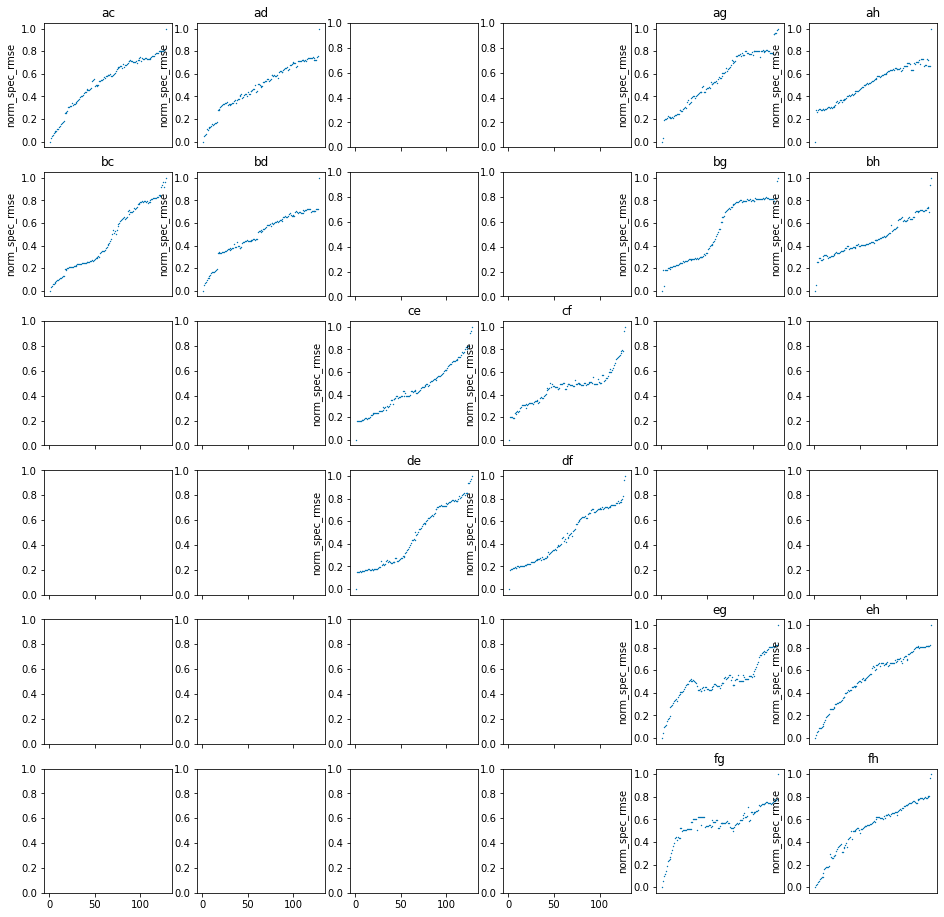

In [96]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='norm_spec_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
#     ax[row][col].get_yaxis().set_visible(False)

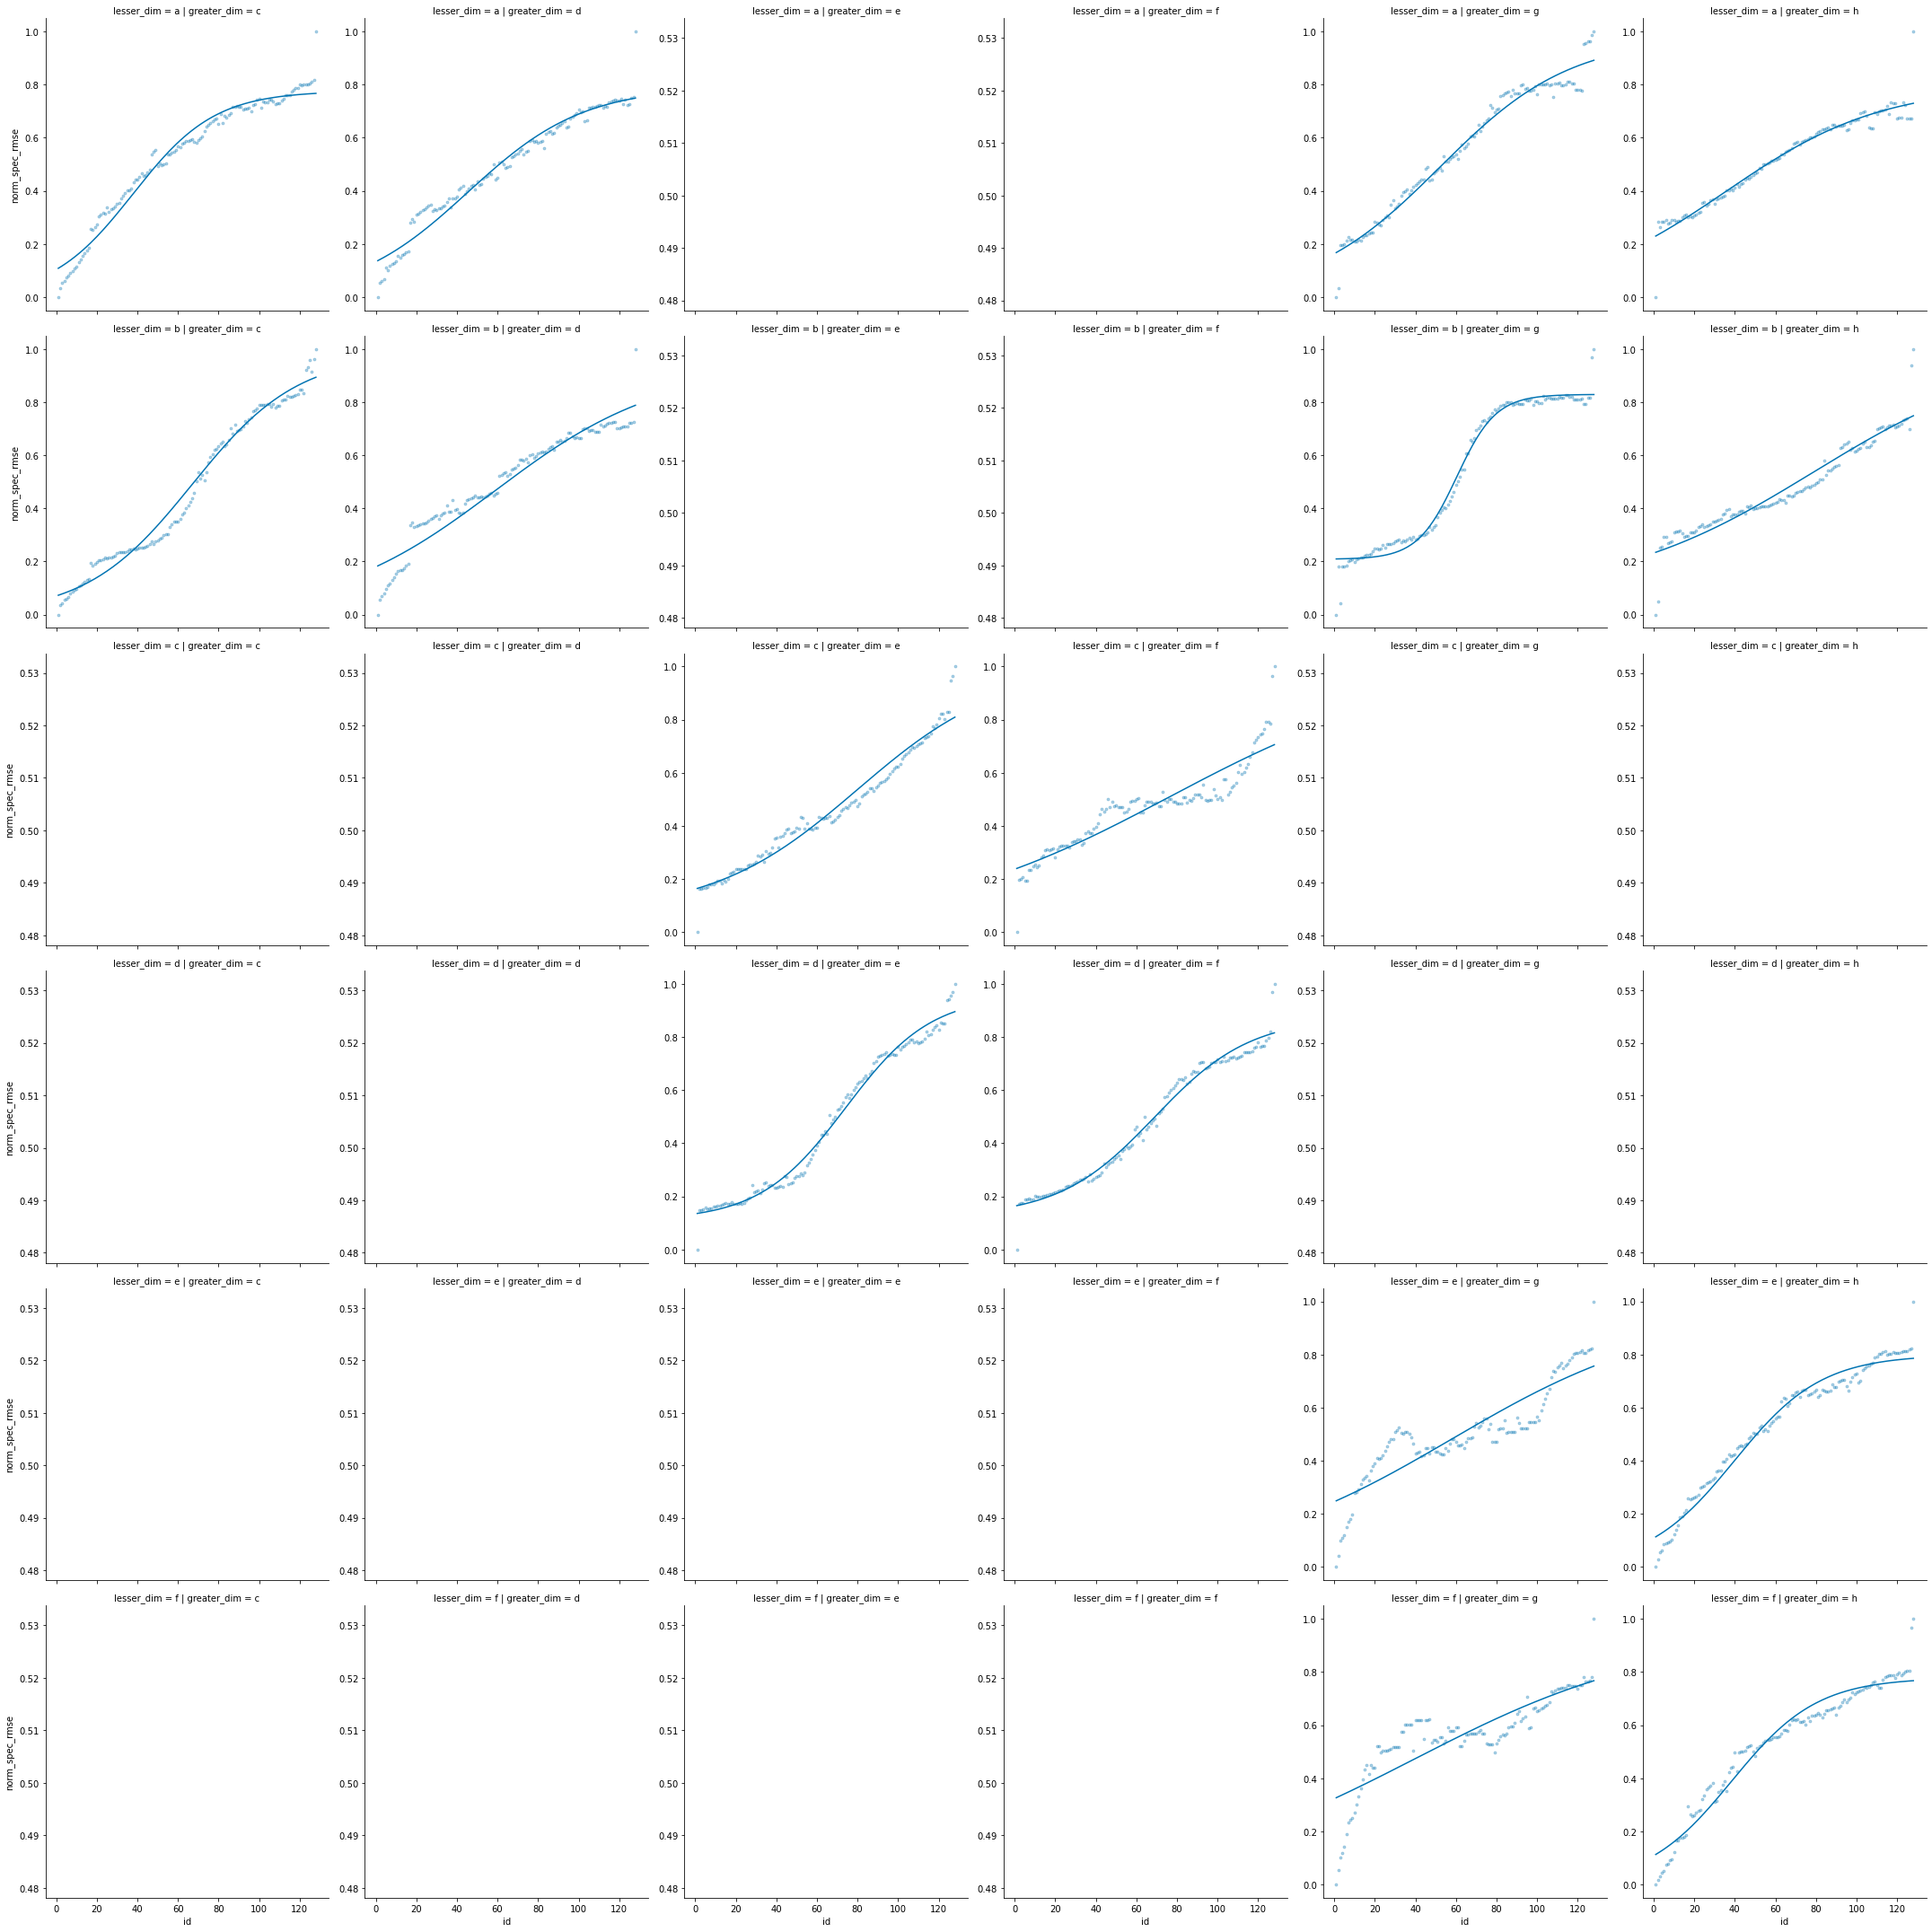

In [124]:
g = sns.lmplot(data=morph_df_sym, 
           x='id', 
           y='norm_spec_rmse', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(_4pl, "id", "norm_spec_rmse")

## feature RMSE

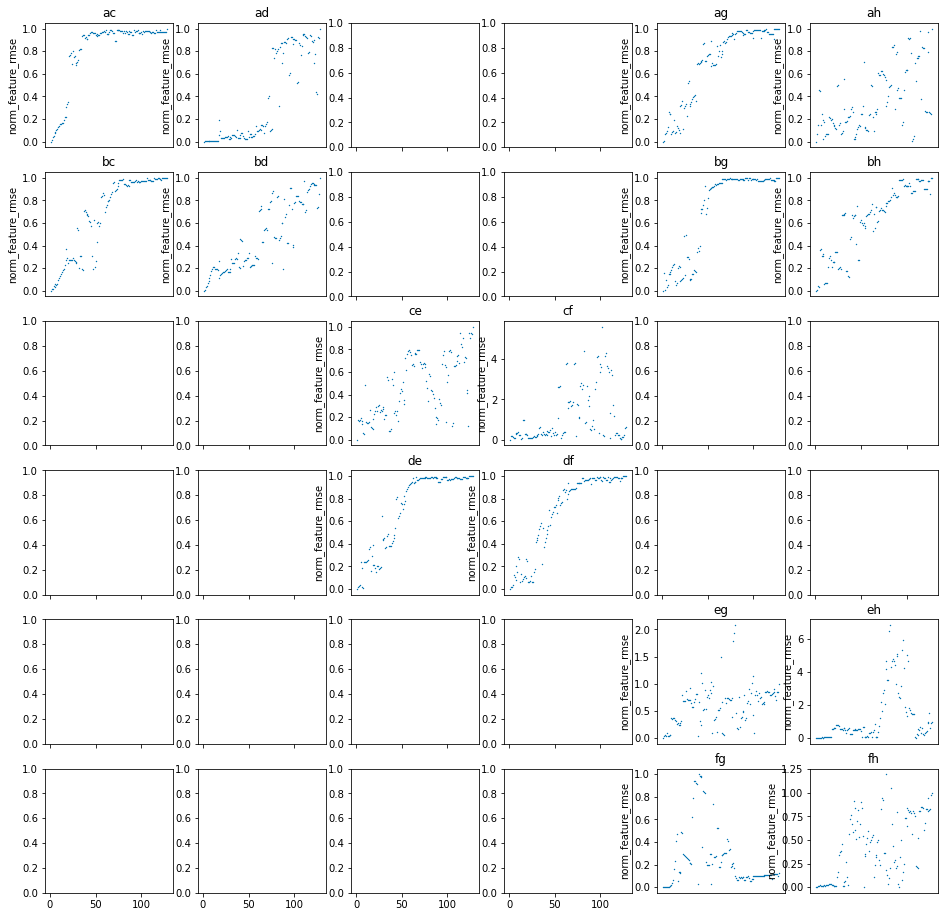

In [98]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)    
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='norm_feature_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
#     ax[row][col].get_yaxis().set_visible(False)

## feature cosine

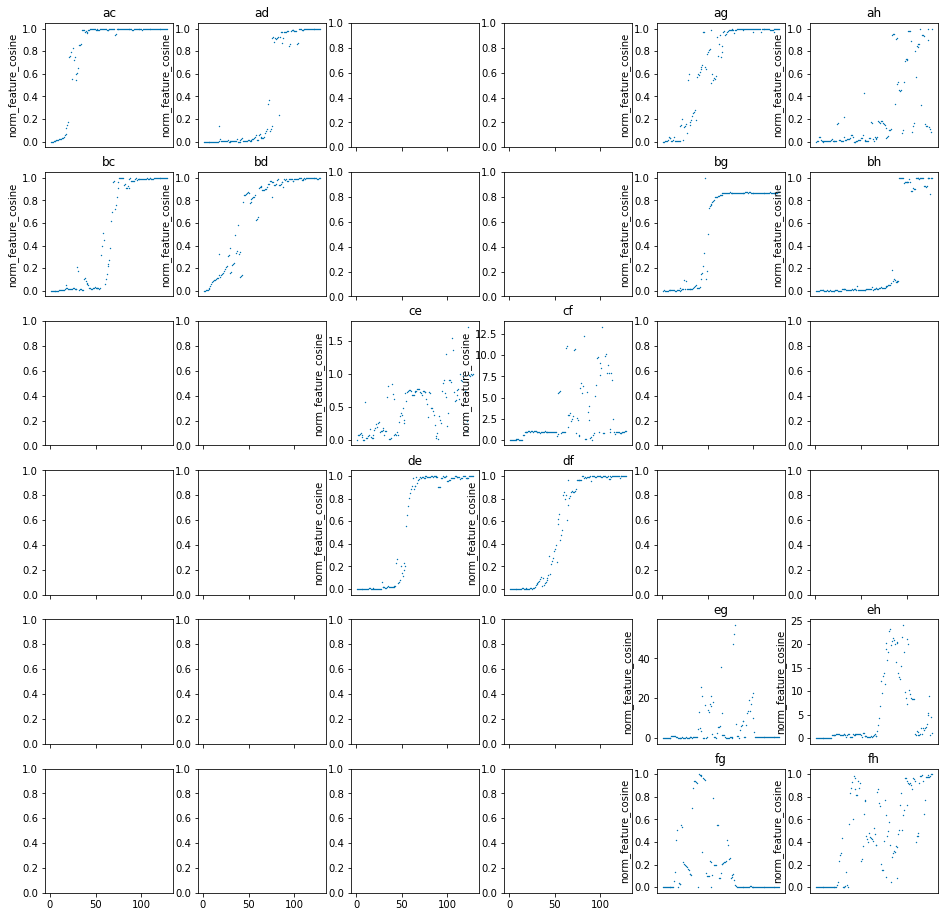

In [99]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='norm_feature_cosine', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
#     ax[row][col].get_yaxis().set_visible(False)

[1.00000000e-16 1.00000000e+00 4.95040313e-02 2.68368728e+01]
[9.05570971e-03 9.94648213e-01 1.10956097e+01 2.13121644e+01]
[ 0.03179335  0.99298555  0.53201916 23.18276119]
[ 1.71052810e-01  1.00000000e-16 -2.56255550e-02  3.43194929e+01]
[2.11133029e-03 9.99888920e-01 2.53521266e-01 7.21981091e+01]
[2.72310918e-03 9.99811287e-01 2.90621342e-01 8.49325334e+01]
[1.36162598e-03 9.98911001e-01 3.62274322e-01 5.39446482e+01]
False
[ 0.05272478  0.9995516   0.45165639 41.15666243]
[ 0.03544692  0.87749682 14.82048159 32.11751877]


/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square


[2.52317440e-02 7.75480857e-01 3.40281173e-01 3.64688030e+01]
[ 0.10689657  0.92129891  0.47347366 52.39801778]
[3.11203300e-03 9.98987917e-01 1.82656215e+00 5.62322090e+01]
[1.33126591e-03 9.99785468e-01 6.18558089e-01 5.77626641e+01]
[1.00000000e-16 9.98901688e-01 1.68912350e-01 6.27351454e+01]
[3.11795625e-03 6.40119299e-01 8.56166790e-02 9.49262091e+01]


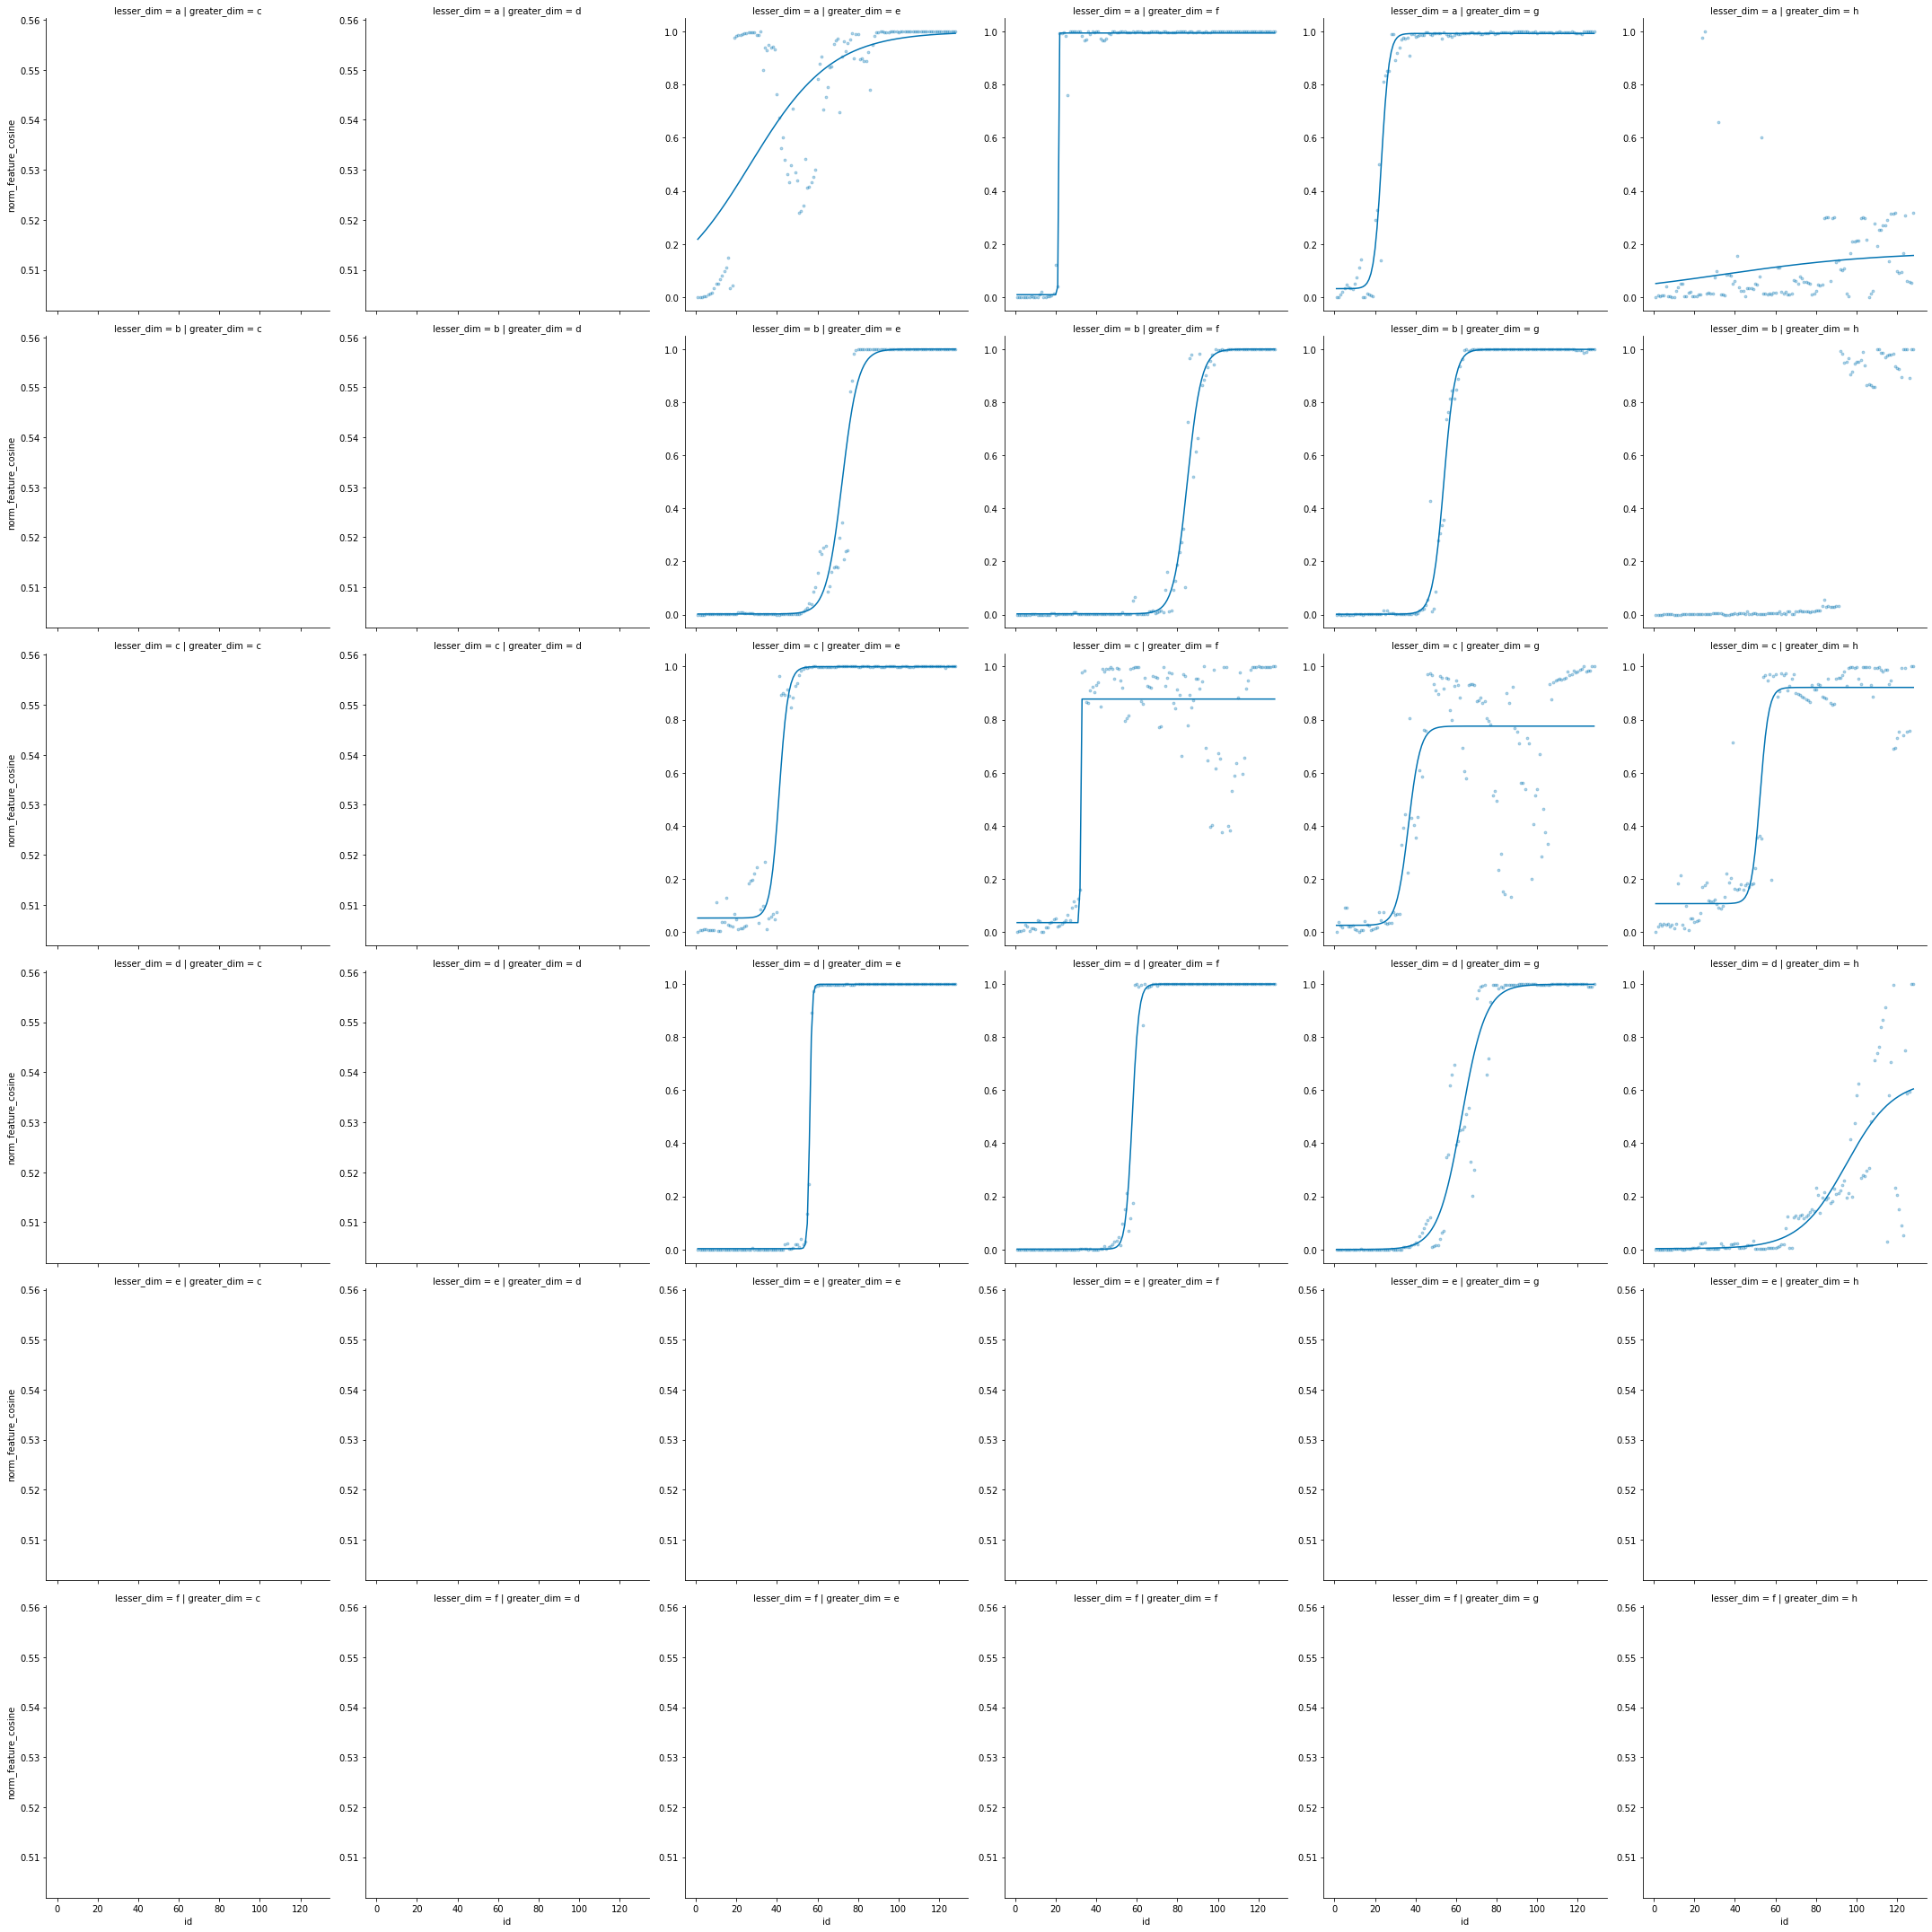

In [55]:
g = sns.lmplot(data=morph_df_sym, 
           x='id', 
           y='norm_feature_cosine', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(_4pl, "id", "norm_feature_cosine")

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in power
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in power
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in power
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in power
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in power
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in power
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in power
/home/shc079/miniconda3/envs/tf2.3

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in power
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


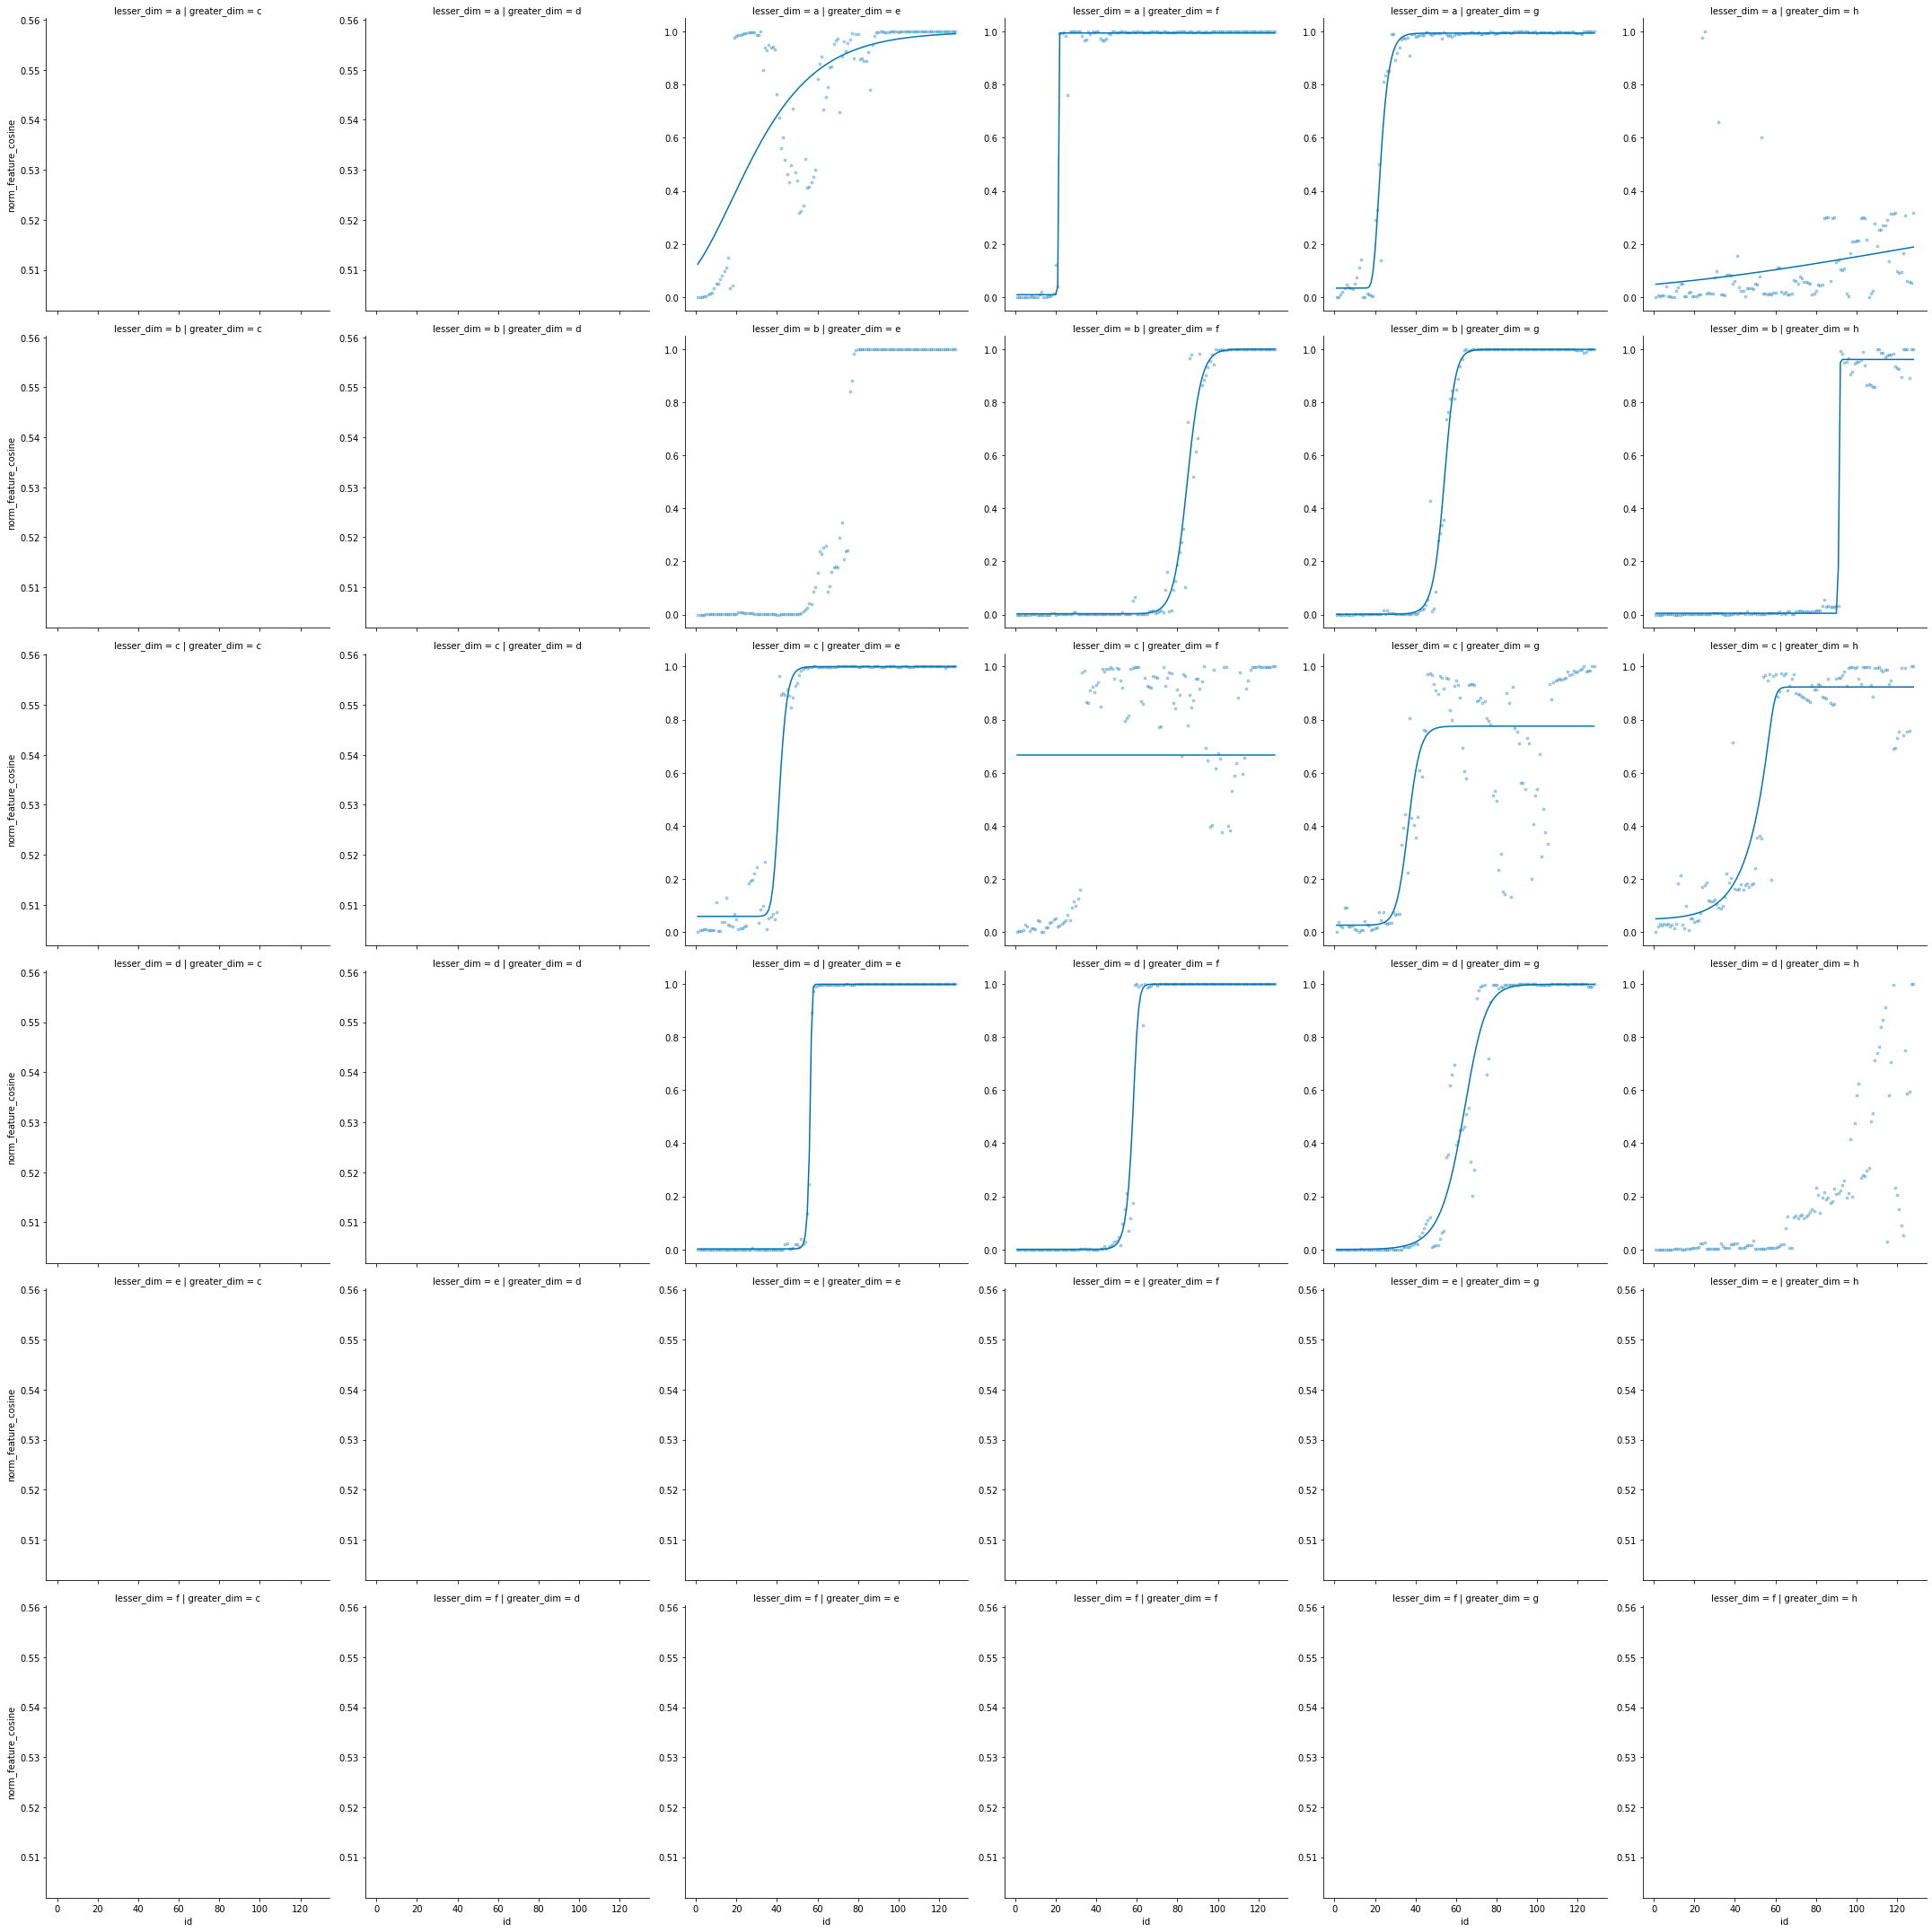

In [46]:
g = sns.lmplot(data=morph_df_sym, 
           x='id', 
           y='norm_feature_cosine', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           scatter_kws={'s':8, 'alpha':0.3}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(_5pl, "id", "norm_feature_cosine")

## analyze accuracy vs behavior

In [213]:
group3_fcosine = {}
group3_frmse = {}
group3_rmse = {}
group3_combo = {}

for i, morph_dim in enumerate(group_stim_cats):
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    ids = np.array(reduced_morph_df.id.values.tolist())
    fcosine_l = np.array(reduced_morph_df.norm_feature_cosine.values.tolist())
    frmse_l = np.array(reduced_morph_df.norm_feature_rmse.values.tolist())
    rmse_l = np.array(reduced_morph_df.norm_spec_rmse.values.tolist())
    combo_l = 0.1*np.array(reduced_morph_df.norm_spec_rmse.values.tolist())+0.9*np.array(reduced_morph_df.norm_feature_rmse.values.tolist())
    fcosine_p = fit_4pl(ids, fcosine_l)
    frmse_p = fit_4pl(ids, frmse_l)
    rmse_p = fit_4pl(ids, rmse_l)
    combo_p = fit_4pl(ids, combo_l)
    
    if isinstance(fcosine_p, bool) or isinstance(frmse_p, bool) or isinstance(rmse_p, bool):
        continue
    else:
        group3_fcosine[morph_dim] = fcosine_p
        group3_frmse[morph_dim] = frmse_p
        group3_rmse[morph_dim] = rmse_p
        group3_combo[morph_dim] = combo_p

/mnt/cube/kai/repositories/star_scale/math_utils.py:424: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2
/mnt/cube/kai/repositories/star_scale/math_utils.py:306: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:418: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
/mnt/cube/kai/repositories/star_scale/math_utils.py:421: RuntimeWarning: overflow encountered in exp
  temp1 = np.exp(-B * (x - M))
/mnt/cube/kai/repositories/star_scale/math_utils.py:424: RuntimeWarning: invalid value encountered in true_divide
  temp2 = temp1 / (1.0 + temp1) ** 2
/mnt/cube/kai/repositories/star_scale/math_utils.py:398: RuntimeWarning: divide by zero encountered in log
  return np.sum(y * np.log(probs) + (1 - y) * np.log(1 - probs))
/mnt/cube/kai/repositories/star_scale/math_utils.py:398: RuntimeWarning: invalid value encountered in 

In [214]:
group3_df_combo = pd.DataFrame.from_dict(group3_combo, 
                                            orient='index', 
                                            columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()
group3_df_rmse = pd.DataFrame.from_dict(group3_rmse, 
                                            orient='index', 
                                            columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()
group3_df_frmse = pd.DataFrame.from_dict(group3_frmse, 
                                            orient='index', 
                                            columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()
group3_df_fcosine = pd.DataFrame.from_dict(group3_fcosine, 
                                            orient='index', 
                                            columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()

group3_df_combo['group'] = 'Group 3'
group3_df_rmse['group'] = 'Group 3'
group3_df_frmse['group'] = 'Group 3'
group3_df_fcosine['group'] = 'Group 3'

group3_df_combo['metric'] = 'combo'
group3_df_rmse['metric'] = 'rmse'
group3_df_frmse['metric'] = 'frmse'
group3_df_fcosine['metric'] = 'fcosine'

group3_df = pd.concat([group3_df_rmse, group3_df_frmse, group3_df_fcosine, group3_df_combo]).reset_index(drop=True)

In [215]:
group3_df.tail()

,index,min_val,max_val,slope,inflection,group,metric
47,eg,2.067038e-01,1.000000,0.020807,66.738856,Group 3,combo
48,eh,9.579996e-02,1.000000,1.309746,62.894005,Group 3,combo
49,df,3.089193e-02,0.961798,0.078660,40.899068,Group 3,combo
50,fg,1.000000e-16,0.607129,-0.010917,44.796033,Group 3,combo
51,fh,1.000000e-16,0.978186,0.025524,75.363846,Group 3,combo


In [16]:
group3_df.to_pickle(os.path.join(results_folder, 'group3_predicted.p'))

In [15]:
group3_df = pickle.load(open(os.path.join(results_folder, 'group3_predicted.p'), 'rb'))

group3_df = group3_df[group3_df.metric.isin(['frmse', 'fcosine','rmse'])].reset_index(drop=True)

In [217]:
group3_df = pd.concat([group3_df, 
                       pickle.load(open(os.path.join(results_folder, 'group3_behav.p'), 'rb'))]).reset_index(drop=True)

(0.0, 1.0)

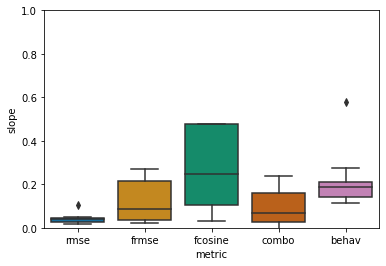

In [219]:
ax = sns.boxplot(y='slope', x='metric',data=group3_df)
ax.set_ylim([0,1])

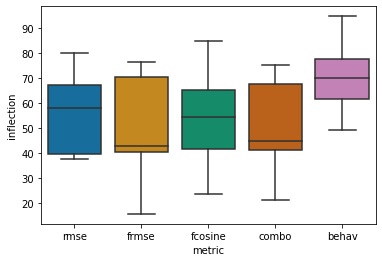

In [220]:
ax = sns.boxplot(y='inflection', x='metric',data=group3_df)
# ax.set_ylim([0,1])

In [20]:
from scipy.stats import ttest_rel

In [17]:
slope_df = group3_df.pivot(index='index',columns='metric',values='slope')

In [18]:
slope_df.dropna(inplace=True)

In [22]:
slope_df

metric,fcosine,frmse,rmse
index,,,
ac,0.247081,0.174662,0.049462
ad,0.278257,0.268822,0.035117
ag,0.103799,0.072723,0.030870
bc,0.231519,0.064951,0.038250
bd,0.087136,0.034440,0.024342
bg,0.476172,0.220171,0.103552
ce,0.032729,0.020262,0.028130
de,0.305766,0.122810,0.047254
df,0.146983,0.085749,0.042349


In [21]:
print(ttest_rel(slope_df['behav'], slope_df['rmse']))

KeyError: 'behav'

In [225]:
print(ttest_rel(slope_df['behav'], slope_df['frmse']))

Ttest_relResult(statistic=-0.260563031687244, pvalue=0.7988469663123305)


In [226]:
print(ttest_rel(slope_df['behav'], slope_df['fcosine']))

Ttest_relResult(statistic=-1.1853122622048364, pvalue=0.2588363370850402)


In [227]:
print(ttest_rel(slope_df['behav'], slope_df['combo']))

Ttest_relResult(statistic=0.31331946467664984, pvalue=0.7594169658731842)


In [228]:
inflection_df = group3_df.pivot(index='index',columns='metric',values='inflection')

In [229]:
inflection_df.dropna(inplace=True)

In [230]:
inflection_df

metric,behav,combo,fcosine,frmse,rmse
index,,,,,
ac,70.222668,21.160534,23.614964,20.748936,37.757563
ad,76.000209,74.074790,75.437140,74.271075,45.444632
ag,61.882029,36.315081,41.450169,35.929178,52.000076
bc,69.493321,42.536397,65.369657,40.875979,67.000628
bd,81.025303,67.472879,40.885439,67.870567,59.000542
bg,60.827771,43.372929,46.989735,42.826063,60.408414
ce,61.606547,70.399672,64.999797,70.399576,79.998174
de,49.383199,41.304947,54.632239,41.136172,74.121979
df,56.879763,40.899068,54.346147,40.261908,69.001853


In [231]:
print(ttest_rel(inflection_df['behav'], inflection_df['rmse']))

Ttest_relResult(statistic=2.2733531777146454, pvalue=0.04218178630697167)


In [232]:
print(ttest_rel(inflection_df['behav'], inflection_df['frmse']))

Ttest_relResult(statistic=2.815997856081066, pvalue=0.01557515269731837)


In [233]:
print(ttest_rel(inflection_df['behav'], inflection_df['fcosine']))

Ttest_relResult(statistic=3.061983268377995, pvalue=0.009862629389995967)


In [234]:
print(ttest_rel(inflection_df['behav'], inflection_df['combo']))

Ttest_relResult(statistic=3.772974966572958, pvalue=0.002657354915444234)


In [236]:
import statsmodels.api as sm
import statsmodels.formula.api as smf